<a href="https://colab.research.google.com/github/AntoineGilsonGH/Statistical-Assessment-of-Trained-Models/blob/main/3_Statistical_Assessment_One_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Assessment of your Model

# 0 - Machine Learning Theory

## Trained ML Model

Let $\hat{f_A}$ be a trained ML model:

$$\hat{f_A} : \mathcal{X} \rightarrow \mathcal{Y} \quad x \mapsto \hat{f_A}(x)$$

In medical imaging, typically, $x$ is an image (or a video) and $y$ can be any type of output, for instance, a real number (regression), a class (classification), a segmentation map (segmentation), an image (image translation).

We will also consider simpler examples where $\mathcal{X} = \mathbb{R}$ or $\mathcal{X} = \mathbb{R^d}$.

## Ground-Truth Function

Let $g$ be the function which associates any input to the ground-truth prediction:

$$g : \mathcal{X} \rightarrow \mathcal{Y} \quad x \mapsto g(x)$$

**Note:** One could also denote $f$ the ground-truth function that $\hat{f_A}$ approximates but it can be convenient to have separate notations, in particular for the cases where the ground-truth itself will be uncertain or if we have multiple ground-truths (for example if we have multiple raters).

## Validation Metric

Let $metric$ be a validation metric:

$$metric : \mathcal{Y} \times \mathcal{Y} \rightarrow \mathbb{R} \quad (y, y') \mapsto metric(y, y')$$

**Note:** For example,
- Segmentation:
  - $metric(y, y') = \text{DSC}(y, y')$
  - $metric(y, y') = \text{HD}_{95}(y, y')$
- Classification:
  - $metric(y, y') = \delta_{y, y'}$
- Regression:
  - $metric(y, y') = |y - y'|$
  - $metric(y, y') = (y - y')^2$

## Model Performance

The performance of model $f$ on input $x$ will thus be:

$$metric(f(x), g(x))$$

## Random Variable $V_A$

Let $\Omega$ be the sample space corresponding to all possible inputs. Here we consider the case of a trained model (as opposed to a learning procedure), thus the only randomness comes from the test examples and we have $\Omega = \mathcal{X}$. One considers the following random variable $V_A$ which provides the performance of $\hat{f_A}$ according to the metric $metric$ on a given input $x$:

$$V_A : \Omega \rightarrow \mathbb{R} \quad x \mapsto V(x) = metric(\hat{f_A}(x), g(x))$$

We will assume that the first and second-order moments of $V_A$ exist and are denoted respectively $\mu_A$ and $\sigma_A^2$.

# Questions/Aims

### Visualize the data and the quality of the model fits
- Provide descriptive statistics and graphs for the performance metric on the test samples.
  - Which statistics and graphs are the most adequate to describe the results (look at the empirical distribution of the metric)
- How precise is the estimation of $\mu_A$ by the empirical mean $m_A$?
  - Associated tools: standard error of the mean, confidence interval
  - Methods: parametric estimates (consider different cases when $n$ is small versus large and when $V_A$ is assumed to be Gaussian or not), bootstrap estimates
- Is model $\hat{f_A}$ obtained with method $A$ better/worse than model $\hat{f_B}$ obtained with method $B$?
  - Associated tools: confidence interval on the difference in performance, statistical tests (paired)
  - Methods: parametric tests, bootstrap tests

# 0 - Required librairies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import uniform, norm, skew, kurtosis
import json
import math
import re
import seaborn as sns
from statsmodels.stats.diagnostic import lilliefors

We also define auxilary functions, helping later (ignore it)

In [ ]:
def extract_bounds(intervals):
        if isinstance(intervals, pd.Interval):
            return [intervals.left], [intervals.right]
        elif all(isinstance(interval, pd.Interval) for interval in intervals):
            lower_bounds = [interval.left for interval in intervals]
            upper_bounds = [interval.right for interval in intervals]
            return lower_bounds, upper_bounds
        else:
            raise TypeError("All elements must be pandas Interval objects or a single Interval object")

def extract_info(filename):
    #
    match = re.search(r'_(.*?)_(.*?)_(.*?)\.csv', filename)
    if match:
        return match.group(1), match.group(2), match.group(3)
    else:
        return None, None, None



# Pick up your dataframe

Please select "model", "metric" and "additional" as it will be used to save a json file reporting the performance of your model

In [ ]:
filename = "/content/data_matrix_grandchallenge.csv"
model = 8
metric = 'DCS'
additional = 'BRATS_L1'


# Example of preprocessing

In [ ]:
errors_file = pd.read_csv(filename)
errors_file = errors_file[errors_file['subtask']==additional]
errors_file = errors_file[errors_file['score']==metric]
errors_file = errors_file[errors_file['alg_number']==model]
errors_file = errors_file['value']
errors = errors_file.values.flatten()
n = len(errors)

# model, metric, additional = extract_info(filename)

print(f"The model name is: {model}")
print(f"The metric is: {metric}")
print(f"The additional info is: {additional}")
print("The size of your sample is:", len(errors))

The model name is: 8
The metric is: DCS
The additional info is: BRATS_L1
The size of your sample is: 263


# If your data is contained in an excel

We suppose here that :
- the name of the sheet is the name of the model you want to assess
- the name of the column is the name of the metrics that has been used
- "additional" : is any information you would need to help you remember the specifictity of this file, ex a special value for a parameter, a special way the data has been collected..

In [ ]:
"""
file_path_excel = "/content/MICCAI.xlsx"
excel_file = pd.ExcelFile(file_path_excel)

your_sheet = excel_file.sheet_names[3] # your sheet
model = excel_file.sheet_names[3] # we suppose the name of your sheet is the name of your model

df = pd.read_excel(file_path_excel, sheet_name=your_sheet)

your_errors = df.iloc[:, 1] # your column
metric = df.columns[1] # we suppose the name of your column is the name of your metric

errors = your_errors.values.flatten()

# To add manually
additional = "" # If you need something more to remember your model

print(f"The model name is: {model}")
print(f"The metric is: {metric}")
print(f"The additional info is: {additional}")
"""

'\nfile_path_excel = "/content/MICCAI.xlsx"\nexcel_file = pd.ExcelFile(file_path_excel)\n\nyour_sheet = excel_file.sheet_names[3] # your sheet\nmodel = excel_file.sheet_names[3] # we suppose the name of your sheet is the name of your model\n\ndf = pd.read_excel(file_path_excel, sheet_name=your_sheet)\n\nyour_errors = df.iloc[:, 1] # your column\nmetric = df.columns[1] # we suppose the name of your column is the name of your metric\n\nerrors = your_errors.values.flatten()\n\n# To add manually\nadditional = "" # If you need something more to remember your model\n\nprint(f"The model name is: {model}")\nprint(f"The metric is: {metric}")\nprint(f"The additional info is: {additional}")\n'

## Feel free to change several things according to your statistical needs with your model !

# I - Descriptive statistics

We first provide descriptive statistics and graphs for the performance metrics on the test sample for the model.

Here, on the same graph a jittered plot of the performance metric and a box plot with the median and the IQR, and an histogram of errors values  

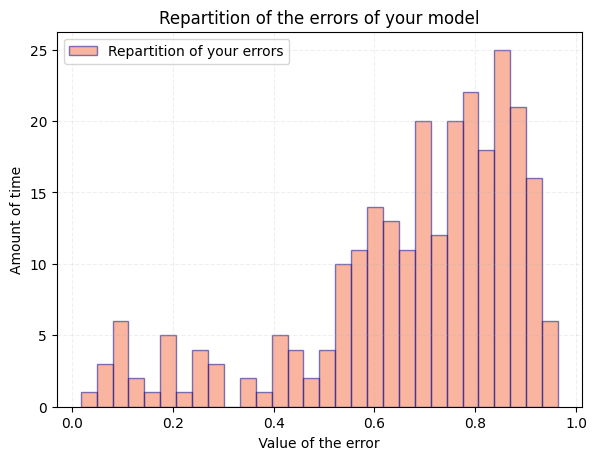

<ipython-input-236-4ac0835724a6>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, errors, alpha=1, color='#f46d43', edgecolor='#f46d43', s=10, label='Data points', linewidths = 2, cmap='viridis')


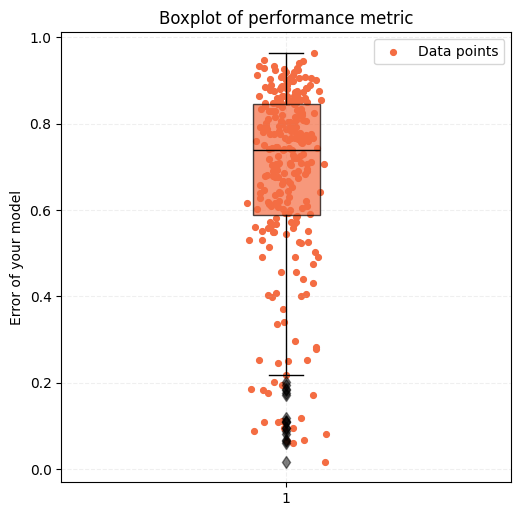

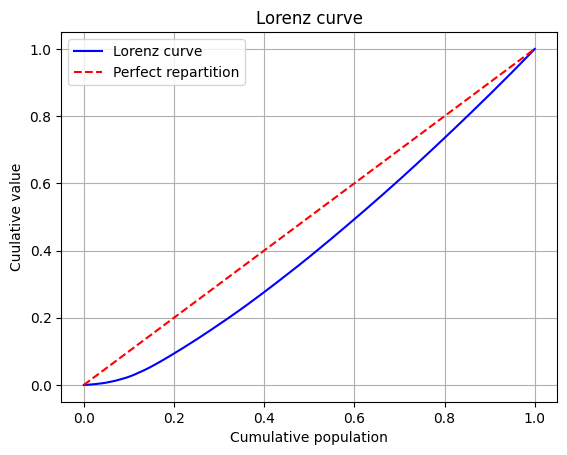

In [ ]:
def hist_errors():

          fig = plt.figure(figsize=(7,5))
          ax = fig.add_axes([0.15,0.15,0.75,0.75])

          plt.title("Repartition of the errors of your model")
          plt.hist(errors, bins=30, label=f"Repartition of your errors", color="#f46d43", edgecolor='darkblue',
                   alpha=0.5, rwidth = 1)
          plt.xlabel(" Value of the error ")
          plt.ylabel("Amount of time")
          plt.grid(True, linestyle='--', alpha=0.2)
          plt.legend()
          plt.show()

hist_errors()

def boxplot_errors():

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0.15,0.15,0.75,0.75])
    x = np.random.normal(1, 0.04, size=len(errors))

    ax.scatter(x, errors, alpha=1, color='#f46d43', edgecolor='#f46d43', s=10, label='Data points', linewidths = 2, cmap='viridis')
    ax.boxplot(errors, vert=True, patch_artist=True, boxprops=dict(facecolor="#f46d43", color='black', alpha = 0.7), medianprops=dict(color='black'), whiskerprops=dict(color='black'),
               capprops=dict(color='black'), flierprops=dict(marker='d', color='black', alpha=0.5, markerfacecolor='black'))
    ax.set_title("Boxplot of performance metric"),
    ax.set_ylabel("Error of your model")
    ax.grid(True, linestyle='--', alpha=0.2)
    ax.legend()

    plt.show()

boxplot_errors()

def lorentz_curve():

   errors_conc = np.sort(errors)
   cum_data = np.cumsum(errors_conc)
   cum_data = cum_data / cum_data[-1]
   cum_data = np.insert(cum_data, 0, 0)

   x = np.linspace(0, 1, len(cum_data))

   plt.plot(x, cum_data, label='Lorenz curve', color='blue')
   plt.plot([0, 1], [0, 1], label='Perfect repartition', color='red', linestyle='--')
   plt.xlabel("Cumulative population")
   plt.ylabel("Cuulative value")
   plt.title("Lorenz curve")
   plt.legend()
   plt.grid(True)
   plt.show()

lorentz_curve()

Here, we report **the empirical mean $m$, the empirical standard-deviation $s$, the median, and the IQR.**

In [ ]:
def descriptive_statistics():

    empirical_mean = np.mean(errors)
    empirical_std_deviation = np.std(errors, ddof=1)
    q1 = np.percentile(errors, 25)
    med = np.percentile(errors, 50)
    q3 = np.percentile(errors, 75)
    skewness = skew(errors)
    kurt = kurtosis(errors)

    print("The empirical mean is :", empirical_mean)
    print("The empirical standard deviation is :", empirical_std_deviation)
    print("The empirical first quartile is :", q1)
    print("The empirical mediane is :", med)
    print("The empirical third quartile is :", q3)
    print("The skewness is;", skewness) # -2 < -1 < -0.5 < 0 < 0.5 < 1 < 2
    print("The kurtosis is;", kurt) #  uniform < 0 < extremas

    return empirical_mean, empirical_std_deviation, q1, med, q3, skewness, kurt

empirical_mean, empirical_std_deviation, q1, med, q3, skewness, kurt = descriptive_statistics()

The empirical mean is : 0.6770722979540569
The empirical standard deviation is : 0.2182782027867223
The empirical first quartile is : 0.589093427467186
The empirical mediane is : 0.739716908266159
The empirical third quartile is : 0.845199063465577
The skewness is; -1.2441370563095773
The kurtosis is; 0.9462955369558967


# Distribution of the errors

We are trying to see if our distribution follows a classic / well known distribution.
Select all the distributions you want to test your model with, using statistical significance

In [ ]:
distributions = {'Normal': stats.norm, 'chi-2': stats.chi2,
                 'poisson': stats.poisson, 'Exp': stats.expon,
                 'gamma': stats.gamma, 'weibull_min': stats.weibull_min,
                 'weibull_max': stats.weibull_max,
                 'cauchy': stats.cauchy, 'lognorm': stats.lognorm,
                 'beta prime': stats.betaprime, 'triangulaire': stats.triang,
                 'logistic': stats.logistic, 'beta': stats.beta}

## Kolmogorov Smirnov test


The Kolmogorov-Smirnov test is a non-parametric test that compares the sample distribution with a reference probability distribution (in this case, a normal distribution). It evaluates the maximum distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution.

If the p_value is below 0.05, the null hypothesis of the similarity of your errors with a known distribution is rejected.

In [ ]:
def test_ks(errors, distributions):

    ks_results = []

    for name, dist in distributions.items():
        if name == 'Normal':
            stat, p_value = lilliefors(errors, dist='norm')
            ks_results.append((f"{name} (Lilliefors)", stat, p_value))
        elif name == 'chi-2':
            for k in [1, 2, 3, 4, 5]:
                ks_test = stats.kstest(errors, 'chi2', args=(k,))
                ks_results.append((f"chi-2 (df={k})", ks_test[0], ks_test[1]))
            continue
        else:
            try:
                ks_test = stats.kstest(errors, dist.cdf, args=dist.fit(errors))
            except Exception as e:
                print(f"Could not adjust this distrbution, {name}: {e}")
                continue

            ks_results.append((name, ks_test[0], ks_test[1]))

    ks_sorted = sorted(ks_results, key=lambda x: x[2], reverse=True)
    return ks_sorted

ks_results_df = pd.DataFrame(test_ks(errors, distributions), columns = ['Distribution', 'Stat', 'p_value'])
print(ks_results_df)

Could not adjust this distrbution, poisson: 'poisson_gen' object has no attribute 'fit'
           Distribution      Stat        p_value
0           weibull_max  0.041813   7.310442e-01
1           weibull_min  0.066543   1.860940e-01
2              logistic  0.109601   3.311742e-03
3                  beta  0.113206   2.160984e-03
4   Normal (Lilliefors)  0.122615   1.000000e-03
5               lognorm  0.122708   6.561598e-04
6            beta prime  0.125609   4.473009e-04
7                 gamma  0.140140   5.726637e-05
8          triangulaire  0.154368   6.136077e-06
9                cauchy  0.156818   4.085599e-06
10         chi-2 (df=1)  0.368058   1.846507e-32
11                  Exp  0.368150   1.777542e-32
12         chi-2 (df=2)  0.619028   1.204380e-97
13         chi-2 (df=3)  0.810280  3.434520e-188
14         chi-2 (df=4)  0.915186  3.128665e-282
15         chi-2 (df=5)  0.965407   0.000000e+00


/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


## Comparing the empirical CDF / PDF with theoritical distributions

norm (0.6770722979540569, 0.21786282999779086)
weibull_max (1.5934067748817824, 1, 0.36256930518582997)
weibull_min (3.6563571273567628, 0, 0.7439992916618082)
cauchy (0.7555955034656543, 0.10569043299691659)
logistic (0.7077088604585551, 0.11629921668800086)
beta (2.588765838493216, 1.3552558993082935, 0, 1)


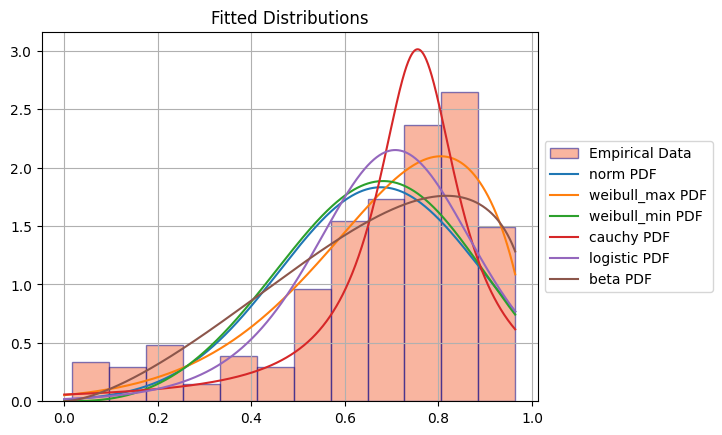

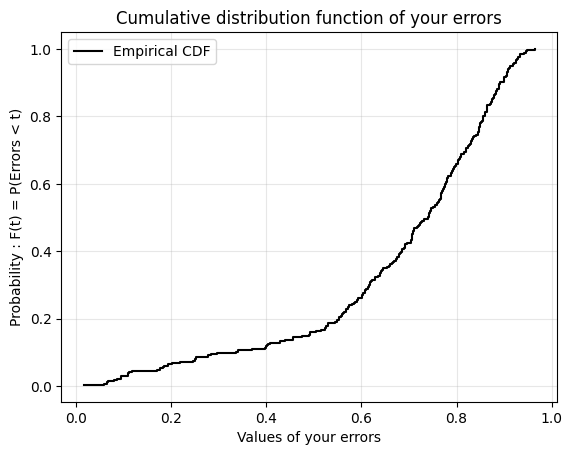

norm (0.6770722979540569, 0.21786282999779086)
weibull_max (1.5934067748817824, 1, 0.36256930518582997)
weibull_min (3.6563571273567628, 0, 0.7439992916618082)
cauchy (0.7555955034656543, 0.10569043299691659)
logistic (0.7077088604585551, 0.11629921668800086)
beta (2.588765838493216, 1.3552558993082935, 0, 1)


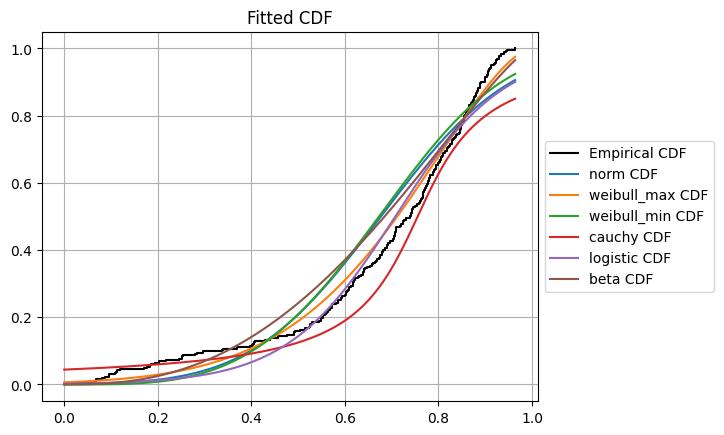

In [ ]:
from enum import auto

distributions_dice = {'norm': stats.norm,
                 'weibull_max': stats.weibull_max,
                 'weibull_min': stats.weibull_min,
                 'cauchy': stats.cauchy,
                 'logistic': stats.logistic,
                 'beta': stats.beta} # the ones working most of the time for DICE

def plot_distributions(errors, distributions):

    plt.hist(errors, bins="auto", label='Empirical Data', density=True, color="#f46d43", edgecolor='darkblue',
                   alpha=0.5, rwidth = 1)
    x = np.linspace(0, np.max(errors), 1000)

    for name, dist in distributions.items():
        if name in ['chi-2', 'gamma', 'weibull_min', 'lognorm', 'beta prime']:
            params = dist.fit(errors, floc=0)
        elif name =='weibull_max':
            params = dist.fit(errors, floc=1)
        elif name =='beta':
            params = dist.fit(errors, floc=0, fscale=1)
        else:
            params = dist.fit(errors)

        print(name, params)
        pdf_fitted = dist.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])
        plt.plot(x, pdf_fitted, label=f'{name} PDF')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Fitted Distributions')
    plt.grid()
    plt.show()

    values = np.sort(errors)
    empirical_cdf = np.arange(1, len(errors)+1) / len(errors)

    plt.figure()
    plt.step(values, empirical_cdf, where='post', label='Empirical CDF', color= 'black', alpha=1)
    plt.title("Cumulative distribution function of your errors")
    plt.xlabel("Values of your errors")
    plt.ylabel("Probability : F(t) = P(Errors < t)")
    plt.legend()
    plt.grid(alpha = 0.3)
    plt.show()

    plt.step(values, empirical_cdf, where='post', label='Empirical CDF', color= 'black', alpha=1)

    for name, dist in distributions.items():
        if name in ['chi-2', 'gamma', 'weibull_min', 'lognorm', 'beta prime']:
            params = dist.fit(errors, floc=0)
        elif name =='weibull_max':
            params = dist.fit(errors, floc=1)
        elif name =='beta':
            params = dist.fit(errors, floc=0, fscale=1)
        else:
            params = dist.fit(errors)

        print(name, params)
        pdf_fitted = dist.cdf(x, *params[:-2], loc=params[-2], scale=params[-1])
        plt.plot(x, pdf_fitted, label=f'{name} CDF')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Fitted CDF')
    plt.grid()
    plt.show()

plot_distributions(errors, distributions_dice)

## MSE of your empirical CDF with theoritical CDFs

In [ ]:
from scipy.interpolate import interp1d

def compare_MSE_CDF(data, distributions):

    x = np.linspace(0, np.max(errors), 1000)
    MSE = []
    values = np.sort(errors)
    empirical_cdf = np.arange(1, len(errors)+1) / len(errors)

    for name, dist in distributions.items():
        if name in ['chi-2', 'gamma', 'weibull_min', 'lognorm', 'beta prime', 'beta']:
            params = dist.fit(errors, floc=0)
        elif name =='weibull_max':
            params = dist.fit(errors, floc=1)
        else:
            params = dist.fit(errors)

        pdf_fitted = dist.cdf(values, *params[:-2], loc=params[-2], scale=params[-1])
        mse_value = np.mean((empirical_cdf - pdf_fitted)**2)
        MSE.append((name, mse_value))

    MSE_sorted = sorted(MSE, key=lambda x: x[1])
    return MSE_sorted


MSE_df = pd.DataFrame(compare_MSE_CDF(errors, distributions_dice), columns=['Distribution', 'MSE CDF'])
print(MSE_df)

  Distribution   MSE CDF
0  weibull_max  0.001164
1     logistic  0.002279
2         beta  0.003314
3       cauchy  0.005356
4         norm  0.005588
5  weibull_min  0.006217


/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


## Divergence KL with the PDF

In [ ]:
from scipy.stats import entropy

def compare_KL(data, distributions):

    counts, bins = np.histogram(data, bins=30, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    x = np.linspace(0, np.max(data), 1000)

    KL_divergences = []

    for name, dist in distributions.items():
        if name in ['chi-2', 'gamma', 'weibull_min', 'lognorm', 'beta prime', 'beta']:
            params = dist.fit(data, floc=0)
        elif name == 'weibull_max':
            params = dist.fit(data, floc=1)
        else:
            params = dist.fit(data)

        pdf_fitted = dist.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])
        pdf_fitted_at_bins = np.interp(bin_centers, x, pdf_fitted)

        kl_divergence = entropy(counts, pdf_fitted_at_bins)
        KL_divergences.append((name, kl_divergence))

    KL_divergences_sorted = sorted(KL_divergences, key=lambda x: x[1])
    return KL_divergences_sorted

KL_df = pd.DataFrame(compare_KL(errors, distributions_dice), columns=['Distribution', 'KL divergence'])
print(KL_df)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


  Distribution  KL divergence
0  weibull_max       0.113790
1       cauchy       0.152152
2         beta       0.157056
3     logistic       0.184525
4         norm       0.220760
5  weibull_min       0.275255


## Computing the Likelihood, AIC, BIC

In [ ]:
def log_likelihood(data, dist, params):
    return np.sum(dist.logpdf(data, *params))

def AIC(log_likelihood, num_params):
    return 2 * num_params - 2 * log_likelihood

def BIC(log_likelihood, num_params, num_data_points):
    return num_params * np.log(num_data_points) - 2 * log_likelihood

In [ ]:
def compare_LL_AIC_BIC(errors,distributions):

    results = []

    for name, dist in distributions.items():
        if name in ['chi-2', 'gamma', 'weibull_min', 'lognorm', 'beta prime']:
            params = dist.fit(errors, floc=0)
        elif name =='weibull_max':
            params = dist.fit(errors, floc=1)
        elif name =='beta':
            params = dist.fit(errors, floc=0, fscale=1)
        else:
            params = dist.fit(errors)

        ll = log_likelihood(errors, dist, params)

        num_params = len(params)

        aic = AIC(ll, num_params)
        bic = BIC(ll, num_params, len(errors))

        results.append((name, ll, aic, bic))

    results_sorted = sorted(results, key=lambda x: x[1], reverse=True)
    results_df = pd.DataFrame(results_sorted, columns=['Distribution', 'Log Likelihood', 'AIC', 'BIC'])

    best_likelihood = max(results, key=lambda x: x[1])
    best_aic = min(results, key=lambda x: x[2])
    best_bic = min(results, key=lambda x: x[3])

    print(f'Best distribution according to likelihood: {best_likelihood[0]}')
    print(f'Best distribution according to AIC: {best_aic[0]}')
    print(f'Best distribution according to BIC: {best_bic[0]}')

    return results_df

results_df = compare_LL_AIC_BIC(errors,distributions_dice)
print(results_df)

Best distribution according to likelihood: weibull_max
Best distribution according to AIC: weibull_max
Best distribution according to BIC: weibull_max
  Distribution  Log Likelihood         AIC         BIC
0  weibull_max       74.255038 -142.510077 -131.793615
1         beta       58.997332 -109.994665  -95.706049
2     logistic       35.330621  -66.661242  -59.516934
3         norm       27.602140  -51.204279  -44.059971
4  weibull_min       16.994599  -27.989199  -17.272737
5       cauchy       16.739191  -29.478383  -22.334075


## Others statistical tests to reach statistical significance

In [ ]:
def chi_square_test(data, distributions, bins=20):

    results = []
    for name, distribution in distributions.items():
        params = distribution.fit(data)

        observed_freq, bin_edges = np.histogram(data, bins=bins)

        cdf = distribution.cdf(bin_edges, *params)
        expected_freq = len(data) * np.diff(cdf)

        expected_freq *= observed_freq.sum() / expected_freq.sum()

        chi2, p_value = stats.chisquare(observed_freq, expected_freq)

        results.append((name, chi2, p_value, params))

    results_sorted = sorted(results, key=lambda x: x[2], reverse=True)
    results_df = pd.DataFrame(results_sorted, columns=['Distribution', 'Chi-2 Stat', 'Chi-2 p_value', 'Params'])

    return results_df


chi_square_results = chi_square_test(errors, distributions_dice)
print("---------------------------")
print("Chi-2 test results")
print(chi_square_results)


def cramer_von_mises_test(data, distributions):

    results = []
    for name, distribution in distributions.items():

      params = distribution.fit(data)
      def fitted_cdf(x):
            return distribution.cdf(x, *params)

      result = stats.cramervonmises(data, fitted_cdf)
      results.append((name, result.statistic, result.pvalue, params))

    results_sorted = sorted(results, key=lambda x: x[2], reverse=True)
    results_df = pd.DataFrame(results_sorted, columns=['Distribution', 'Cramer Stat', 'Cramer p_value', 'Params'])
    return results_df

cramer_von_mises_results = cramer_von_mises_test(errors, distributions_dice)
print("---------------------------")
print("Cramer test results")
print(cramer_von_mises_results)

from scipy.stats import gumbel_r, gumbel_l

distributions_AD = {'norm': stats.norm,
                 'gumbel_l': stats.gumbel_l,
                 'gumbel_r': stats.gumbel_r,
                 'logistic': stats.logistic,
                 'expon': stats.expon}

def anderson_darling_test(data, distributions):

      results = []
      for name, distribution in distributions_AD.items():

        if name in {'expon', 'logistic', 'gumbel_l', 'norm', 'gumbel_r'}:

           result = stats.anderson(data, dist=name)
           results.append((name, result.statistic, result.critical_values, result.significance_level))

        else:
          continue

      results_df = pd.DataFrame(results, columns=['Distribution', 'AD Stat', 'AD critical values', 'AD Significance level'])

      return results_df

anderson_darling_results = anderson_darling_test(errors, distributions_AD)
print("---------------------------")
print("Anderson Darling test results")
print(anderson_darling_results)

from scipy.stats import shapiro

def shapiro_normality_test(data):
  stat, p_value = shapiro(data)
  return stat, p_value

shapiro_results = shapiro_normality_test(errors)
print("---------------------------")
print("Shapiro normality test")
print(shapiro_results)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


---------------------------
Chi-2 test results
  Distribution  Chi-2 Stat  Chi-2 p_value  \
0  weibull_max   55.192099   2.172046e-05   
1         beta   68.850014   1.426917e-07   
2  weibull_min   94.700318   4.823194e-12   
3       cauchy   95.898014   2.941269e-12   
4         norm  162.666467   7.679876e-25   
5     logistic  165.377778   2.274139e-25   

                                              Params  
0  (1.378223979289463, 0.9651367875800096, 0.3162...  
1  (1.857222562681489, 0.762570194312302, -0.0828...  
2  (281881156.15090877, -42094108.75056497, 42094...  
3          (0.7555955034656543, 0.10569043299691659)  
4          (0.6770722979540569, 0.21786282999779086)  
5          (0.7077088604585551, 0.11629921668800086)  
---------------------------
Cramer test results
  Distribution  Cramer Stat  Cramer p_value  \
0  weibull_max     0.125529        0.473823   
1  weibull_min     0.298639        0.136345   
2     logistic     0.598853        0.022452   
3         beta  

## For each criteria, which distribution has performed the best to fit our errors ?

### Best fit

In [ ]:
print("Best LL/AIC/BIC:", results_df['Distribution'][0],  ";",
      "Best MSE:", MSE_df['Distribution'][0],  ";" ,
      "Best KL:", KL_df['Distribution'][0],";" ,
      "Best KS test:", ks_results_df['Distribution'][0])

Best LL/AIC/BIC: weibull_max ; Best MSE: weibull_max ; Best KL: weibull_max ; Best KS test: weibull_max


### Top 3 fits

In [ ]:
print("Top 3 LL/AIC/BIC:", results_df['Distribution'][0], results_df['Distribution'][1],results_df['Distribution'][2],  ";",
      "Top 3 MSE:", MSE_df['Distribution'][0], MSE_df['Distribution'][1], MSE_df['Distribution'][2], ";" ,
      "Top 3 KL:", KL_df['Distribution'][0], KL_df['Distribution'][1], KL_df['Distribution'][2], ";" ,
      "Top 3 KS test:", ks_results_df['Distribution'][0], ks_results_df['Distribution'][1], ks_results_df['Distribution'][2])

Top 3 LL/AIC/BIC: weibull_max beta logistic ; Top 3 MSE: weibull_max logistic beta ; Top 3 KL: weibull_max cauchy beta ; Top 3 KS test: weibull_max weibull_min logistic


## Kernel Density Estimation (KDE) to create an empirical PDF

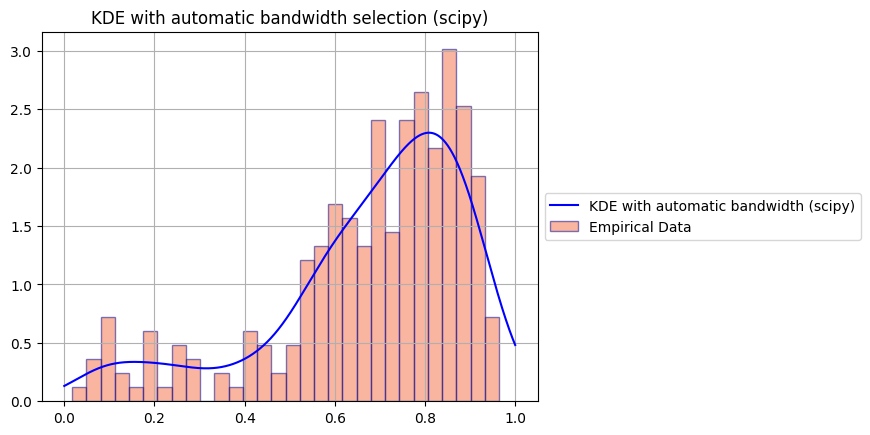

norm (0.6770722979540569, 0.21786282999779086)
weibull_max (1.5934067748817824, 1, 0.36256930518582997)
weibull_min (3.6563571273567628, 0, 0.7439992916618082)
cauchy (0.7555955034656543, 0.10569043299691659)
logistic (0.7077088604585551, 0.11629921668800086)
beta (2.588765838493216, 1.3552558993082935, 0, 1)


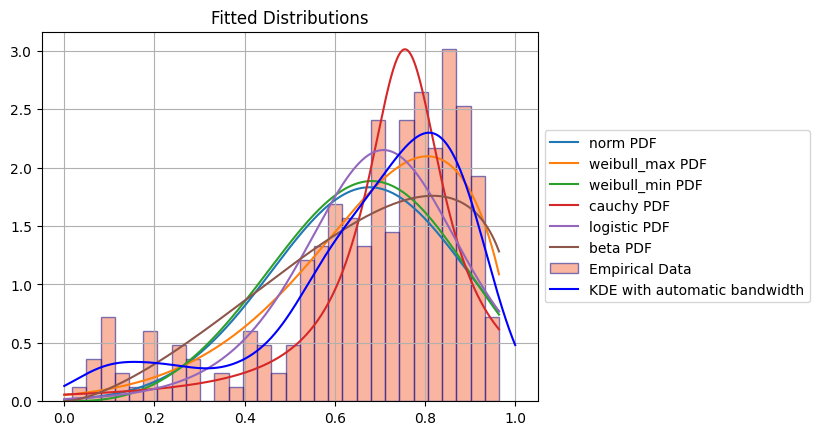

In [ ]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

def compare_kde(errors, distributions):

    x_d = np.linspace(0, 1, 1000)

    kde_scipy = gaussian_kde(errors)
    density_scipy = kde_scipy.evaluate(x_d)

    plt.plot(x_d, density_scipy, label="KDE with automatic bandwidth (scipy)", color='blue')
    plt.hist(errors, bins=30, label='Empirical Data', density=True, color="#f46d43", edgecolor='darkblue',
                       alpha=0.5, rwidth=1)
    plt.title('KDE with automatic bandwidth selection (scipy)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    plt.show()

    x = np.linspace(0, np.max(errors), 1000)

    for name, dist in distributions.items():
        if name in ['chi-2', 'gamma', 'weibull_min', 'lognorm', 'beta prime']:
            params = dist.fit(errors, floc=0)
        elif name == 'weibull_max':
            params = dist.fit(errors, floc=1)
        elif name == 'beta':
            params = dist.fit(errors, floc=0, fscale=1)
        else:
            params = dist.fit(errors)

        print(name, params)
        pdf_fitted = dist.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])
        plt.plot(x, pdf_fitted, label=f'{name} PDF')

    plt.hist(errors, bins=30, label='Empirical Data', density=True, color="#f46d43", edgecolor='darkblue',
                       alpha=0.5, rwidth=1)
    plt.plot(x_d, density_scipy, label="KDE with automatic bandwidth", color='blue')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Fitted Distributions')
    plt.grid()
    plt.show()

compare_kde(errors, distributions_dice)

# II - Inferential Statistics


- How precise is the estimation of $\mu$ by the empirical mean $m$?
  - Standard error of the mean
    - Derive formulas (or algorithms) for the standard error ($SE$) of the mean
      Methods: parametric estimates, bootstrap estimates

  - Confidence interval
    - Derive formulas (or algorithms) for confidence interval of the mean
      Methods: using standard-error computed above (consider different cases when $n$ is small versus large and when $V_A$ is assumed to be Gaussian or not), using bootstrap


## Standard Error of the Mean

The standard error of the mean $SE(n\_test)$ is a measure of the dispersion of the sample mean from the true population mean. It is calculated using the sample standard deviation $s$ divided by the square root of the test sample size $n\_test$.

**When n\_test is large**, the Central Limit Theorem gives us the following formula:

$$
\bar{X} \sim \mathcal{N}\left(\mu, \frac{\sigma}{\sqrt{n_test}}\right)
$$

This expression leads to the expression of the standard error of the mean, $SE$ :

$$
SE(n\_test) = \frac{\sigma}{\sqrt{n\_test}}
$$

where:
- $σ$ is the sample standard deviation,
- $n\_test$ is the test sample size.

This formula helps to understand how much the sample mean is likely to vary from the true population mean. The larger the sample size, the smaller the standard error of the mean, indicating a more precise estimate of the population mean. This is referred to as parametric estimation.

**On the other hand,**

**When n\_test is small**, we no longer can use the Central Limit Theorem to compute the standard error.


Indeed, When the sample size n\_test is small, the distribution of the sample mean may not be approximately normal. This leads to:
- Non-normal sampling distribution
- Biased standard error
- Inaccurate confidence intervals

We need to use a **bootstrapped method** to determine the standard error.


**If you are working with a Classifier :**

We can rewrite the model as following :   

$$
X \sim \mathcal{B}\left(p\right)
$$

where p is probability that the classifier predicts the correct value.

Thus $ V(X) = σ^2 = p(1-p)$, and $SE = \sqrt{\frac{p(1-p)}{n}}$

In [ ]:
def standard_error():

    std_error_param = empirical_std_deviation/(len(errors)**0.5) # Parametric estimate

    B = 250 # Bootstrap estimate
    bootstrap_indices = np.random.choice(len(errors), size=(B, len(errors)), replace=True)

    bootstrap = []

    for indices in bootstrap_indices:
      boot_mean = np.mean(errors[indices])
      bootstrap.append(boot_mean)

    bootstrapped_mean = np.mean(bootstrap)
    bootstrapped_std_error = np.std(bootstrap)

    print("The original empirical mean is :", empirical_mean)
    print("The bootstrapped empirical mean is :", bootstrapped_mean)

    print("The empirical standard error is :", std_error_param)
    print("The bootstrapped empirical standard error is :", bootstrapped_std_error)

    return std_error_param, bootstrapped_std_error, bootstrap, bootstrapped_mean

std_error_param, bootstrapped_std_error, bootstrap, bootstrapped_mean = standard_error()


The original empirical mean is : 0.6770722979540569
The bootstrapped empirical mean is : 0.6770924412192425
The empirical standard error is : 0.013459610587054093
The bootstrapped empirical standard error is : 0.013822052117609843


### Check of the normality assumption of the distribution of the mean

We can check if the bootstrapped distribution is normal centered around the empirical mean

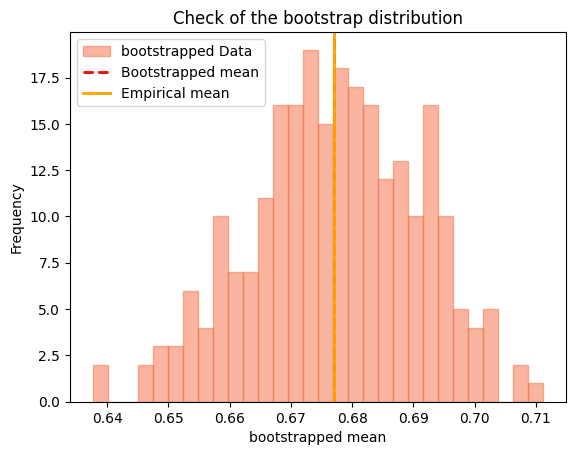

In [ ]:
plt.title("Check of the bootstrap distribution")
plt.hist(bootstrap, bins=30, alpha=0.5, color='#f46d43', edgecolor='#f46d43',label='bootstrapped Data')
plt.axvline(bootstrapped_mean, color='r', linestyle='dashed', linewidth=2, label='Bootstrapped mean')
plt.axvline(empirical_mean, color='orange', linestyle='-', linewidth=2, label='Empirical mean')
plt.xlabel("bootstrapped mean")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Confidence intervals of the mean, various bootstrapped methods

When the sample size \(n\) is sufficiently large, we can use the Central Limit Theorem to determine a confidence interval for the mean using the standard error.

### Theory
According to the Central Limit Theorem (CLT), if the sample size n is large (typically 30 is considered large enough), the distribution of the sample mean $\bar{X}$ will be approximately normally distributed, even if the original population distribution is not normal.

$$
\bar{X} \sim \mathcal{N}\left(\mu, \frac{\sigma}{\sqrt{n}}\right)
$$

The confidence interval for the mean would be given by:
$$\bar{X} \pm Z*\frac{\sigma}{\sqrt{n}}$$

**But in the most general case**, we can assume that the distribution of the mean follows a standard student distribution, that converges towards a normal distribution when n is large. Moreover we don't have information on $σ$, that we empirically determine with $s$.

$$\bar{X} \sim \mathcal{T}\left(n-1\right)$$ where n is the length of errors file.

The confidence interval for the mean is given by:
$$\bar{X} \pm t*\text{SE}$$
where:
- $\bar{X}$ is the sample mean.
- $t$ is the critical value from the student distribution for the desired confidence level, and with the corresponding degrees of freedom
- $\text{SE}$ is the empirical standard error of the mean, calculated as $\text{SE} = \frac{s}{\sqrt{n}}$.

This is the "parametric" interval

Else, we have **to bootstrap** the mean and take quantiles in order to make a 95% interval. We'll use 3 differents bootstrap techniques.

Moreover, we can add new parameters to analyse how precise is our estimation. Indeed :

We define the width of the confidence interval (CI) as:

$w = b - a$

So for instance, when the parametric estimation is used, the width is given by:

$w = 2 \times 1.96 \times \text{SEM}$


We normalize the width by the mean value of the metric. To this end, we define the normalized width as:

$\nu = \frac{w}{\mu}$

In [ ]:
def mean_statistic(data):
    return np.mean(data, axis=-1)

## Different bootstrap methods used :

Reminder : we have bootstraped (contained in the 'bootstrap' list) the value of the mean of our performance metric, here denoted as $m_1^*, m_2^*, ..., m_B^* $. The real value of the mean is $μ$, the empirical mean is $m$

### Percentile bootstrap

The percentile bootstrap uses the most intuitive percentiles of the bootstrap distribution, to create à 95% confidence interval:

$\left(\theta^*_{(\alpha / 2)}, \; \theta^*_{(1 - \alpha / 2)}\right)$
where $\theta^*_{(1 - \alpha / 2)}$ denotes the $1 - \alpha / 2$ percentile of the bootstrapped coefficients $\theta^*$.

### Basic bootstrap

The basic bootstrap (also known as the $\textbf{Reverse Percentile Interval}$) proceeds in a similar way to the basic bootstrap, using percentiles of the bootstrap distribution, but with a different formula (note the inversion of the left and right quantiles):

$\left(2\hat{\theta} - \theta^*_{(1 - \alpha / 2)}, \; 2\hat{\theta} - \theta^*_{(\alpha / 2)}\right)$
where $\theta^*_{(1 - \alpha / 2)}$ denotes the $1 - \alpha / 2$ percentile of the bootstrapped coefficients $\theta^*$

### Bias corrected accelerated bootstrap

The Bias-Corrected and Accelerated (BCA) bootstrap method is an advanced technique for constructing confidence intervals that accounts for both bias and skewness in the bootstrap distribution of the estimate. This method enhances the accuracy of the confidence intervals by correcting for bias and adjusting for the acceleration (skewness) of the distribution.

**First : the Bias Correction**

The bias correction step addresses the systematic error in the bootstrap estimates. Indeed, bootstrapped mean is often **upwardly biased** compared to empirical mean. The bias correction factor, denoted as $z_0$, is derived from the proportion of bootstrap estimates that are less than the empirical estimate $\hat{m}$. The formula for $z_0$ is given by:

$$
z_0 = \Phi^{-1} \left( \frac{1}{B} \sum_{b=1}^{B} \mathbf{1} (m^{*b} < \hat{m}) \right)
$$

where $\Phi^{-1}$ is the inverse cumulative distribution function (CDF) of the standard normal distribution, $m^{*b}$ are the bootstrap estimates, and $\hat{m}$ is the empirical estimate. This formula calculates the z-score corresponding to the percentile of bootstrap estimates below the empirical estimate. If many bootstrap estimates are below the empirical estimate, this indicates a negative bias, and vice versa.

**Secondly : the acceleration term**

The acceleration term, $a$, corrects for the skewness of the bootstrap distribution. It measures the rate of change of the standard error with respect to the true parameter value. The acceleration factor is calculated using the jackknife method, which involves systematically leaving out each observation from the sample and recalculating the estimate. The formula for $a$ is:

$$
a = \frac{\sum \left( \bar{\theta}_{\text{jackknife}} - \theta_{(i)} \right)^3}{6 \left( \sum \left( \bar{\theta}_{\text{jackknife}} - \theta_{(i)} \right)^2 \right)^{3/2}}
$$

where $\bar{\theta}_{\text{jackknife}}$ is the mean of the jackknife estimates, and $\theta_{(i)}$ are the individual jackknife estimates. This formula involves the third and second central moments of the jackknife estimates. A nonzero $a$ indicates asymmetry in the distribution of the estimate, and the correction helps to adjust for this skewness.

**Finally : the adjusted percentiles**

Using the bias correction factor $z_0$ and the acceleration factor $a$, the adjusted percentiles for the confidence interval are calculated. The formulas for the lower and upper percentiles are:

$$
\text{Lower percentile} = \Phi \left( z_0 + \frac{z_0 + z_{\alpha / 2}}{1 - a(z_0 + z_{\alpha / 2})} \right) \times 100
$$

$$
\text{Upper percentile} = \Phi \left( z_0 + \frac{z_0 + z_{1 - \alpha / 2}}{1 - a(z_0 + z_{1 - \alpha / 2})} \right) \times 100
$$

where $z_{\alpha / 2}$ and $z_{1 - \alpha / 2}$ are the critical values from the standard normal distribution for the given confidence level $\alpha$. These percentiles are then used to determine the BCA bootstrap confidence interval by taking the corresponding percentiles of the bootstrap distribution.

### Bias corrected bootstrap (BC)

We adjust the percentiles with a bias correction term but we don't include the acceleration term for the convergence. **Thus a = 0** Normally, as the computers are more powerful than we they were in the past, we should find the same results.

The percentiles are the following :

$$
\text{Lower percentile} = \Phi ( 2z_0 +  z_{\alpha / 2} ) \times 100
$$

$$
\text{Upper percentile} = \Phi ( 2z_0 +  z_{1 - \alpha / 2} ) \times 100
$$


### Other types of bootstrap

Other ways of bootstrapping can be found in various articles, for example in <u>"Computer Age Statistical Inference"</u> from Bradley Efron & Trevor Hastie, <u>"Bootstrap methods and their application"</u> from A.C. Davison & D.V. Hinkley, or <u>"An Introduction to the Bootstrap"</u> from Bradley Efron & RobertJ. Tibshirani.

We can talk for instance about Studentized Bootstrap, Moving Blocks Bootstrap, Bayesian Bootstrap...

Feel free to complete this notebook !

### Theoritical comparison on bootstrap methods

With the 4 various methods we have chosen to determine our intervals, there are some theoritical results that we should find empirically.

- Overall, the BCA bootstrap is supposed to be the best replication of the parametric method, because it corrects the problems of other methods
- The parametric method, as explained earlier, should be inaccurate as the sample size decreases (because CLT doesn't apply anymore)
- The basic bootstrap is not really effective with small sample sizes either, with 90% confidence intervals only containing the real value 78% of the time (Wikipedia). It is said to be less accurate than its percentile counterpart, especially in asymmetric case, because it requiers a symmetry assumption of the distribution around the observed statistic, here the mean.
- The percentile bootstrap works with every statistic and every distribution. Still it's more efficient when the distribution is symmetrical, centenred around the observed statistic, and the sample statistic is median-unbiased with maximum concentration. The symmetry ensures that the tails of the distribution are equally representative of the variation around the central value, so the percentile method will yield confidence intervals that are centered correctly and have the appropriate coverage probability.
It can still lead to bias and skewness.
- The basic / reverse percentile confidence intervals are easier to justify mathematically but they are less accurate in general than percentile confidence intervals, and some authors discourage their use.

1.969024973902692
A 95'%' confidence parametric interval for the mean is : [0.6505699885691423, 0.7035746073389715]
-------------------------------
A 95'%' percentile boostrap confidence interval for the mean is : [0.6494964091143515, 0.7024958900881283]
-------------------------------
A 95'%' basic boostrap confidence interval for the mean is : [0.6516487058199855, 0.7046481867937623]
-------------------------------
A 95'%' BCA confidence interval for the mean is : [0.64922749 0.70091653]
A 95'%' BC confidence interval for the mean is : [0.64927492 0.70170624]
-------------------------------
Width of the differents intervals :
Width of Parametric interval : 0.053004618769829204
Width of Percentile boot interval : 0.052999480973776825
Width of Basic boot interval : 0.052999480973776825
Width of BCA boot interval : 0.05168904619429371
Width of BC boot interval : 0.05243132086680169
-------------------------------


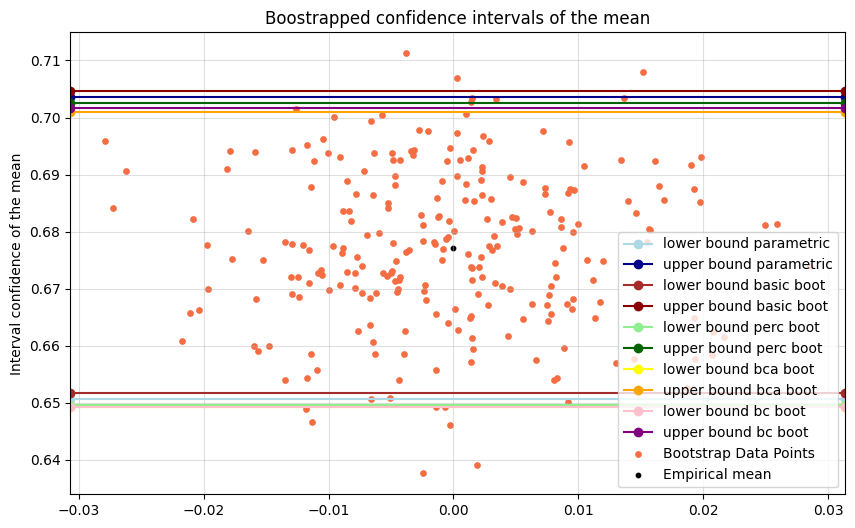

In [ ]:
def confidence_intervals():

    alpha = 0.05 # Confidence level
    n = len(errors)

    t_student = stats.t.ppf(1 - alpha / 2, n)
    print(t_student)
    lower = empirical_mean - t_student * std_error_param # Parametric method with student
    upper = empirical_mean + t_student * std_error_param

    conf_interval = pd.Interval(left=lower, right=upper, closed='both')

    print("A 95'%' confidence parametric interval for the mean is :", conf_interval)

    lower_boot = np.percentile(bootstrap , 100 * (alpha/2))
    upper_boot = np.percentile(bootstrap, 100 * (1 - alpha / 2))

    conf_interval_perc_boot = pd.Interval(left=lower_boot, right=upper_boot, closed='both') # Percentile bootstrap

    print("-------------------------------")

    print("A 95'%' percentile boostrap confidence interval for the mean is :", conf_interval_perc_boot)

    conf_interval_basic_boot = pd.Interval(left=2*empirical_mean-upper_boot, right=2*empirical_mean-lower_boot, closed='both') # basic bootstrap

    print("-------------------------------")

    print("A 95'%' basic boostrap confidence interval for the mean is :", conf_interval_basic_boot)

    # Bias correction
    z0 = stats.norm.ppf(np.mean(bootstrap < empirical_mean))

    z_alpha = norm.ppf(alpha / 2)
    z_1_alpha = norm.ppf(1 - alpha / 2)

    # Acceleration
    jackknife_samples = np.array([np.mean(np.delete(errors, i)) for i in range(len(errors))])
    jackknife_mean = np.mean(jackknife_samples)
    a = np.sum((jackknife_mean - jackknife_samples) ** 3) / (6 * np.sum((jackknife_mean - jackknife_samples) ** 2) ** 1.5)

    lower_percentile = norm.cdf(z0 + (z0 + z_alpha) / (1 - a * (z0 + z_alpha))) * 100
    upper_percentile = norm.cdf(z0 + (z0 + z_1_alpha) / (1 - a * (z0 + z_1_alpha))) * 100

    conf_interval_bca_boot = np.percentile(bootstrap, [lower_percentile, upper_percentile]) # BCA bootstrap`

    a = 0 # BC bootstrap

    lower_percentile = norm.cdf(z0 + (z0 + z_alpha) / (1 - a * (z0 + z_alpha))) * 100
    upper_percentile = norm.cdf(z0 + (z0 + z_1_alpha) / (1 - a * (z0 + z_1_alpha))) * 100

    conf_interval_bc_boot = np.percentile(bootstrap, [lower_percentile, upper_percentile])

    print("-------------------------------")

    print("A 95'%' BCA confidence interval for the mean is :", conf_interval_bca_boot)
    print("A 95'%' BC confidence interval for the mean is :", conf_interval_bc_boot)

    print("-------------------------------")

    print("Width of the differents intervals :")

    narrowness_student = (conf_interval.right - conf_interval.left)
    narrowness_perc = (conf_interval_perc_boot.right - conf_interval_perc_boot.left)
    narrowness_basic = (conf_interval_basic_boot.right - conf_interval_basic_boot.left)
    narrowness_bca = (conf_interval_bca_boot[1] - conf_interval_bca_boot[0])
    narrowness_bc = (conf_interval_bc_boot[1] - conf_interval_bc_boot[0])

    print("Width of Parametric interval :", narrowness_student)
    print("Width of Percentile boot interval :", narrowness_perc)
    print("Width of Basic boot interval :", narrowness_basic)
    print("Width of BCA boot interval :", narrowness_bca)
    print("Width of BC boot interval :", narrowness_bc)

    print("-------------------------------")

    y1, y2 = extract_bounds(conf_interval)
    y3, y4 = extract_bounds(conf_interval_basic_boot)
    y5, y6 = extract_bounds(conf_interval_perc_boot)
    y7, y8 = conf_interval_bca_boot[0], conf_interval_bca_boot[1]
    y9, y10 = conf_interval_bc_boot[0], conf_interval_bc_boot[1]

    plt.figure(figsize=(10, 6))
    plt.axhline(y1, label='lower bound parametric', marker='o', color="lightblue")
    plt.axhline(y2, label='upper bound parametric', marker='o', color="darkblue")
    plt.axhline(y3, label='lower bound basic boot', marker='o', color="brown")
    plt.axhline(y4, label='upper bound basic boot', marker='o', color="darkred")
    plt.axhline(y5, label='lower bound perc boot', marker='o', color="lightgreen")
    plt.axhline(y6, label='upper bound perc boot', marker='o', color="darkgreen")
    plt.axhline(y7, label='lower bound bca boot', marker='o', color="yellow")
    plt.axhline(y8, label='upper bound bca boot', marker='o', color="orange")
    plt.axhline(y9, label='lower bound bc boot', marker='o', color="pink")
    plt.axhline(y10, label='upper bound bc boot', marker='o', color="purple")


    jittered_x = np.random.normal(loc=0, scale=0.01, size=len(bootstrap))

    plt.scatter(jittered_x, bootstrap, alpha=1, color='#f46d43', edgecolor='#f46d43', s=8, label='Bootstrap Data Points', linewidths=2)
    plt.scatter(0, empirical_mean, color = 'black', s =10, label = "Empirical mean")

    plt.xlabel('')
    plt.ylabel('Interval confidence of the mean')
    plt.title('Boostrapped confidence intervals of the mean')
    plt.legend()
    plt.grid(True, alpha =0.4)
    plt.show()

    return (conf_interval, conf_interval_perc_boot, conf_interval_basic_boot, conf_interval_bca_boot, conf_interval_bc_boot,
   narrowness_student, narrowness_perc, narrowness_basic, narrowness_bca, narrowness_bc )

(conf_interval, conf_interval_perc_boot, conf_interval_basic_boot, conf_interval_bca_boot, conf_interval_bc_boot,
   narrowness_student, narrowness_perc, narrowness_basic, narrowness_bca, narrowness_bc ) = confidence_intervals()


In [ ]:
def plot_evolution_confidence_intervals(list_intervals, subset_sizes, title):
   lower_bounds = [interval.left for interval in list_intervals]
   upper_bounds = [interval.right for interval in list_intervals]

   plt.figure(figsize=(10, 6))
   plt.plot(subset_sizes, lower_bounds, label='Lower Bound', marker='o')
   plt.plot(subset_sizes, upper_bounds, label='Upper Bound', marker='o')
   plt.fill_between(subset_sizes, lower_bounds, upper_bounds, color='b', alpha=0.1)
   plt.xlabel('subset_sizes')
   plt.ylabel('Confidence Interval')
   plt.title(f"Evolution of Confidence Intervals, {title}")
   plt.legend()
   plt.grid(True)
   plt.show()

def plot_evolution_confidence_intervals_array(list_intervals, subset_sizes, title):
   lower_bounds = [interval[0] for interval in list_intervals]
   upper_bounds = [interval[1] for interval in list_intervals]
   k_values = range(1, len(list_intervals) + 1)

   plt.figure(figsize=(10, 6))
   plt.plot(subset_sizes, lower_bounds, label='Lower Bound', marker='o')
   plt.plot(subset_sizes, upper_bounds, label='Upper Bound', marker='o')
   plt.fill_between(subset_sizes, lower_bounds, upper_bounds, color='b', alpha=0.1)
   plt.xlabel('subset_sizes')
   plt.ylabel('Confidence Interval')
   plt.title(f"Evolution of Confidence Intervals, {title}")
   plt.legend()
   plt.grid(True)
   plt.show()

def plot_all_confidence_intervals(list_1, list_2, list_3, list_4, list_5, subset_sizes):

   lower_bound_1 = [interval.left for interval in list_1]
   upper_bound_1 = [interval.right for interval in list_1]

   lower_bound_2 = [interval.left for interval in list_2]
   upper_bound_2 = [interval.right for interval in list_2]

   lower_bound_3 = [interval.left for interval in list_3]
   upper_bound_3 = [interval.right for interval in list_3]

   lower_bound_4 = [interval[0] for interval in list_4]
   upper_bound_4 = [interval[1] for interval in list_4]

   lower_bound_5 = [interval[0] for interval in list_5]
   upper_bound_5 = [interval[1] for interval in list_5]

   plt.figure(figsize=(10, 6))

# Parametric bounds
   plt.plot(subset_sizes, lower_bound_1, label='Lower Bound Parametric', marker='o', color='black', linestyle='-')
   plt.plot(subset_sizes, upper_bound_1, label='Upper Bound Parametric', marker='o', color='black', linestyle='-')

# Basic Bootstrap bounds
   plt.plot(subset_sizes, lower_bound_2, label='Lower Bound Basic Boot', marker='s', color='red', linestyle='--')
   plt.plot(subset_sizes, upper_bound_2, label='Upper Bound Basic Boot', marker='s', color='red', linestyle='--')

# Percentile Bootstrap bounds
   plt.plot(subset_sizes, lower_bound_3, label='Lower Bound Perc Boot', marker='^', color='green', linestyle='-.')
   plt.plot(subset_sizes, upper_bound_3, label='Upper Bound Perc Boot', marker='^', color='green', linestyle='-.')

# BCa Bootstrap bounds
   plt.plot(subset_sizes, lower_bound_4, label='Lower Bound BCA Boot', marker='D', color='blue', linestyle=':')
   plt.plot(subset_sizes, upper_bound_4, label='Upper Bound BCA Boot', marker='D', color='blue', linestyle=':')

# BC Bootstrap bounds
   plt.plot(subset_sizes, lower_bound_5, label='Lower Bound BC Boot', marker='v', color='purple', linestyle=(0, (3, 5, 1, 5)))
   plt.plot(subset_sizes, upper_bound_5, label='Upper Bound BC Boot', marker='v', color='purple', linestyle=(0, (3, 5, 1, 5)))

   plt.fill_between(subset_sizes, lower_bound_1, upper_bound_1, color='b', alpha=0.1)
   plt.fill_between(subset_sizes, lower_bound_2, upper_bound_2, color='b', alpha=0.1)
   plt.fill_between(subset_sizes, lower_bound_3, upper_bound_3, color='b', alpha=0.1)
   plt.fill_between(subset_sizes, lower_bound_4, upper_bound_4, color='b', alpha=0.1)
   plt.fill_between(subset_sizes, lower_bound_5, upper_bound_5, color='b', alpha=0.1)

   plt.xlabel('subset_sizes')
   plt.ylabel('Confidence Interval')
   plt.title(f"Evolution of Confidence Intervals, different methods")
   plt.legend()
   plt.grid(True)
   plt.show()

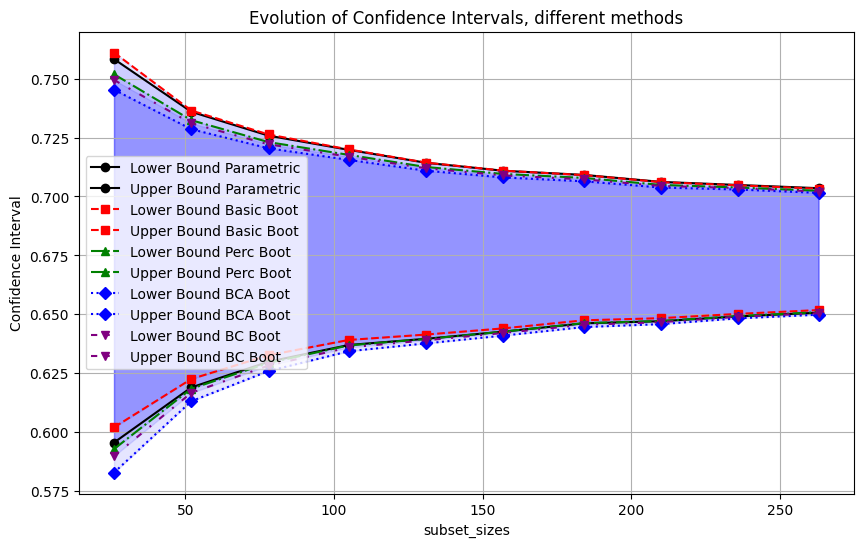

In [ ]:
def averaged_confidence_intervals(k, empirical_mean, num_samples=1000): # k number of progressive subsets you want, num_samples nb of simulation per subset

      alpha = 0.05 # Confidence level
      n = len(errors)

      t_student = stats.t.ppf(1 - alpha / 2, n)

      standard_errors_list_avg = []
      list_classic_intervals_avg = []
      list_classic_boot_intervals_avg = []
      list_percentile_boot_intervals_avg = []
      list_bca_boot_intervals_avg = []
      list_bc_boot_intervals_avg = []

      list_classic_coverage = []
      list_classic_boot_coverage = []
      list_percentile_boot_coverage = []
      list_bca_boot_coverage = []
      list_bc_boot_coverage = []

      n = len(errors)
      subset_sizes_avg = np.linspace(n // k, n, k, dtype=int)

      for size in subset_sizes_avg:

          sem_samples = []
          classic_intervals_samples = []
          classic_boot_intervals_samples = []
          percentile_boot_intervals_samples = []
          bca_boot_intervals_samples = []
          bc_boot_intervals_samples = []

          for _ in range(num_samples):

              data_subset = np.random.choice(errors, size=size, replace=False)

              mean_subset = np.mean(data_subset)
              sem = np.std(data_subset)/np.sqrt(size)

              sem_samples.append(sem)

              B = 250 # Bootstrap estimate
              bootstrap_indices_subset = np.random.choice(len(data_subset), size=(B, len(data_subset)), replace=True)

              bootstrap_subset = []
              for indices in bootstrap_indices_subset:
                  boot_mean_subset = np.mean(data_subset[indices])
                  bootstrap_subset.append(boot_mean_subset)

              bootstrapped_mean_subset = np.mean(bootstrap_subset)
              bootstrapped_std_error_subset = np.std(bootstrap_subset)

              lower = mean_subset - t_student * sem # Parametric method
              upper = mean_subset + t_student * sem
              classic_intervals_samples.append((lower, upper))

              lower_boot = np.percentile(bootstrap_subset , 100 * (alpha/2))
              upper_boot = np.percentile(bootstrap_subset, 100 * (1 - alpha / 2))
              percentile_boot_intervals_samples.append((lower_boot, upper_boot)) # Percentile bootstrap
              classic_boot_intervals_samples.append((2*mean_subset-upper_boot, 2*mean_subset-lower_boot)) # basic bootstrap

              # Acceleration
              jackknife_samples_subset = np.array([np.mean(np.delete(data_subset, i)) for i in range(len(data_subset))])
              jackknife_mean_subset = np.mean(jackknife_samples_subset)
              a_subset = np.sum((jackknife_mean_subset - jackknife_samples_subset) ** 3) / (6 * np.sum((jackknife_mean_subset - jackknife_samples_subset) ** 2) ** 1.5)

              # Bias correction
              z0_subset = stats.norm.ppf(np.mean(bootstrap_subset < mean_subset))
              z_alpha_subset = norm.ppf(alpha / 2)
              z_1_alpha_subset = norm.ppf(1 - alpha / 2)

              lower_percentile = norm.cdf(z0_subset + (z0_subset + z_alpha_subset) / (1 - a_subset * (z0_subset + z_alpha_subset))) * 100
              upper_percentile = norm.cdf(z0_subset + (z0_subset + z_1_alpha_subset) / (1 - a_subset * (z0_subset + z_1_alpha_subset))) * 100

              bca_boot_interval = np.percentile(bootstrap_subset, [lower_percentile, upper_percentile]) # BCA bootstrap
              bca_boot_intervals_samples.append(bca_boot_interval)

              a_subset = 0

              lower_percentile = norm.cdf(z0_subset + (z0_subset + z_alpha_subset) / (1 - a_subset * (z0_subset + z_alpha_subset))) * 100
              upper_percentile = norm.cdf(z0_subset + (z0_subset + z_1_alpha_subset) / (1 - a_subset * (z0_subset + z_1_alpha_subset))) * 100

              bc_boot_interval = np.percentile(bootstrap_subset, [lower_percentile, upper_percentile]) # BC bootstrap
              bc_boot_intervals_samples.append(bc_boot_interval)


          standard_errors_list_avg.append(np.mean(sem_samples))
          list_classic_intervals_avg.append(pd.Interval(left=np.mean([i[0] for i in classic_intervals_samples]), right=np.mean([i[1] for i in classic_intervals_samples]), closed='both'))
          list_classic_boot_intervals_avg.append(pd.Interval(left=np.mean([i[0] for i in classic_boot_intervals_samples]), right=np.mean([i[1] for i in classic_boot_intervals_samples]), closed='both'))
          list_percentile_boot_intervals_avg.append(pd.Interval(left=np.mean([i[0] for i in percentile_boot_intervals_samples]), right=np.mean([i[1] for i in percentile_boot_intervals_samples]), closed='both'))
          list_bca_boot_intervals_avg.append(np.mean(bca_boot_intervals_samples, axis=0))
          list_bc_boot_intervals_avg.append(np.mean(bc_boot_intervals_samples, axis=0))

      return subset_sizes_avg, standard_errors_list_avg, list_classic_intervals_avg, list_classic_boot_intervals_avg, list_percentile_boot_intervals_avg, list_bca_boot_intervals_avg, list_bc_boot_intervals_avg,



subset_sizes_avg, standard_errors_list_avg, list_parametric_intervals_avg, list_classic_boot_intervals_avg, list_percentile_boot_intervals_avg, list_bca_boot_intervals_avg, list_bc_boot_intervals_avg = averaged_confidence_intervals(10, 1000)

plot_all_confidence_intervals(list_parametric_intervals_avg, list_classic_boot_intervals_avg, list_percentile_boot_intervals_avg, list_bca_boot_intervals_avg, list_bc_boot_intervals_avg, subset_sizes_avg)


# Saving all the data into a Json File

In [ ]:
def save_data():

    data = {
    "Empirical mean": empirical_mean,
    "Empirical standard deviation": empirical_std_deviation,
    "Empirical first quartile": q1,
    "Empirical median": med,
    "Empirical third quartile": q3,
    "Bootstrapped empirical mean": bootstrapped_mean,
    "Empirical standard error": bootstrapped_std_error,
    "Bootstrapped empirical standard error": std_error_param,
    "95% confidence parametric interval for the mean": str(conf_interval),
    "95% percentile bootstrap confidence interval for the mean": str(conf_interval_perc_boot),
    "95% basic bootstrap confidence interval for the mean": str(conf_interval_basic_boot),
    "95% accelerated bootstrap confidence interval for the mean": str(conf_interval_bca_boot),
    "Width of parametric interval": narrowness_student,
    "Width of basic bootstrapped interval ": narrowness_basic,
    "Width of percentile bootstrapped interval ": narrowness_perc,
    "Width of BCA bootstrapped interval ": narrowness_bca,
    "Width of BC bootstrapped interval ": narrowness_bc
}

    json_file_path = f"statistics_{model}_{metric}_{additional}_summary.json" # a modifier
    with open(json_file_path, 'w') as json_file:
       json.dump(data, json_file, indent=4)

    print(f"Data have been saved in the file {json_file_path}")

save_data()

Data have been saved in the file statistics_8_DCS_BRATS_L1_summary.json


# The rest of the notebook is shown for a given example, but feel free to duplicate it and make the necessary changes for your distribution

# III - Real Coverage of Confidence intervals

# III.1 - Computing coverage by fitting a parametric distribution on your errors

## Our Example : BRATS_L1, model 8 (nnUnet - 3D)

The objective is to find if our confidence intervals are robust enough to measure precisely the value of the mean of our distribution

## First we have to select the distribution we want to fit and check if it is not too far from our empirical results

### We first compute the real theoritical mean and the parametric confidence interval derived from it

In [ ]:
from scipy.special import gamma

# From our previous analysis, we can make some assumptions about the distributions of the task for this model

# Let's assume the distirbution of the DICE is given by a Weibull Max of parameters :

loc, shape, scale = 1, 1.5934067748817824, 0.36256930518582997
fitted_dist = stats.weibull_max(shape, loc, scale)

# We can estimate the mean of this distribution by moment

real_mean = loc - scale * gamma(1 + 1 / shape)
numpy_std = fitted_dist.std()

n = len(errors)
alpha = 0.05
t_student = stats.t.ppf(1 - alpha / 2, n)
ci_lower = real_mean - t_student * (numpy_std / np.sqrt(n))
ci_upper = real_mean + t_student * (numpy_std / np.sqrt(n))

print("Real mean estimated by moments:", real_mean)
print("Empirical mean:", empirical_mean)

print("Parametric confidence interval for the fitted distribution :", (ci_lower, ci_upper))
print("Original parametric Confidence interval :", conf_interval)

Real mean estimated by moments: 0.6748049243363758
Empirical mean: 0.6770722979540569
Parametric confidence interval for the fitted distribution : (0.6494434780439925, 0.7001663706287592)
Original parametric Confidence interval : [0.6505699885691423, 0.7035746073389715]


### Then we simulate some data in order to see if the fit is good

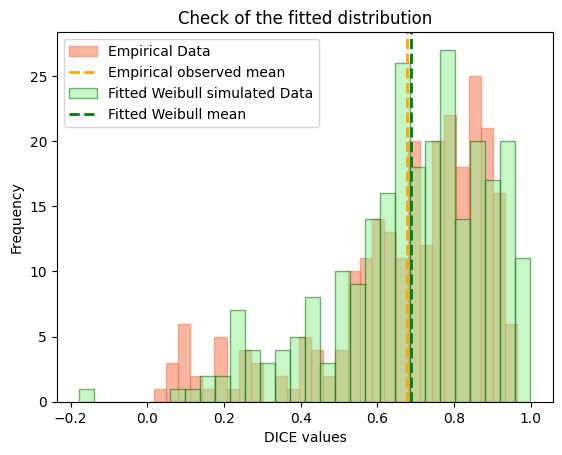

In [ ]:
n = len(errors)

data_sample = stats.weibull_max.rvs(1.5934067748817824, loc=1, scale=0.36256930518582997, size=n)
weibull_mean = np.mean(data_sample)
plt.title("Check of the fitted distribution")
plt.hist(errors, bins=30, alpha=0.5, color='#f46d43', edgecolor='#f46d43',label='Empirical Data')
plt.axvline(empirical_mean, color='orange', linestyle='dashed', linewidth=2, label='Empirical observed mean')
plt.hist(data_sample, bins=30, alpha=0.5, color='lightgreen', edgecolor='darkgreen',label='Fitted Weibull simulated Data')
plt.axvline(np.mean(data_sample), color='g', linestyle='dashed', linewidth=2, label='Fitted Weibull mean')
plt.xlabel("DICE values")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Eventually we simulate 1000 times the fitted distribution to see how its means are distributed and if the normal hypothesis is thus reasonable

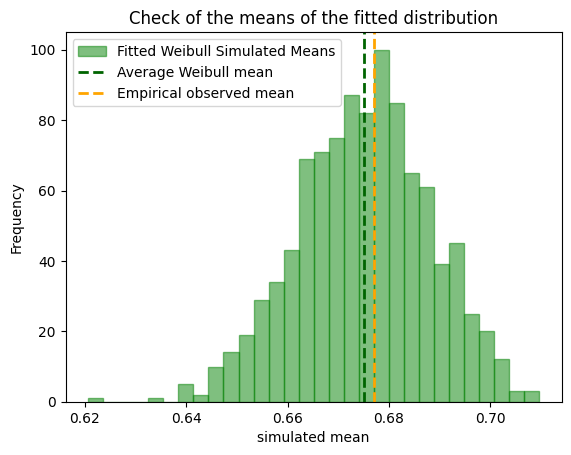

In [ ]:
all_means = []
for _ in range(1000):
  data_sample = stats.weibull_max.rvs(1.5934067748817824, loc=1, scale=0.36256930518582997, size=n)
  mean_sample = np.mean(data_sample)
  all_means.append(mean_sample)

plt.title("Check of the means of the fitted distribution")
plt.hist(all_means, bins=30, alpha=0.5, color='green', edgecolor='green',label='Fitted Weibull Simulated Means')
plt.axvline(np.mean(all_means), color='darkgreen', linestyle='dashed', linewidth=2, label='Average Weibull mean')
plt.axvline(empirical_mean, color='orange', linestyle='dashed', linewidth=2, label='Empirical observed mean ')
plt.xlabel("simulated mean")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Then we compute confidence intervals with all the previous methods and we capture which method is the most reliable as we know the real value of the mean we have to capture in the CI

In [ ]:
def last_coverage_confidence_interval(mean_value, num_samples=1000):

    alpha = 0.05
    size=len(errors)
    t_student = stats.t.ppf(1 - alpha / 2, size - 1)

    standard_errors_list = []
    list_classic_intervals = []
    list_classic_boot_intervals = []
    list_percentile_boot_intervals = []
    list_bca_boot_intervals = []
    list_bc_boot_intervals = []

    list_classic_coverage = []
    list_classic_boot_coverage = []
    list_percentile_boot_coverage = []
    list_bca_boot_coverage = []
    list_bc_boot_coverage = []

    for _ in range(num_samples):

        # Select your distribution, here Weibull Max
        data_sample = stats.weibull_max.rvs(1.5934067748817824, loc=1, scale=0.36256930518582997, size=size)

        mean_sample = np.mean(data_sample)
        sem_sample = np.std(data_sample) / np.sqrt(size)
        standard_errors_list.append(sem_sample)

        lower = mean_sample - t_student * sem_sample
        upper = mean_sample + t_student * sem_sample
        list_classic_intervals.append((lower, upper))
        list_classic_coverage.append(int(lower <= mean_value <= upper))

        # Bootstrap
        B = 250
        bootstrap_indices = np.random.choice(size, size=(B, size), replace=True)
        bootstrap_means = [np.mean(data_sample[indices]) for indices in bootstrap_indices]

        # Percentile bootstrap
        lower_boot = np.percentile(bootstrap_means, 100 * (alpha / 2))
        upper_boot = np.percentile(bootstrap_means, 100 * (1 - alpha / 2))
        list_percentile_boot_intervals.append((lower_boot, upper_boot))
        list_percentile_boot_coverage.append(int(lower_boot <= mean_value <= upper_boot))

        # Basic bootstrap
        classic_boot_interval = (2 * mean_sample - upper_boot, 2 * mean_sample - lower_boot)
        list_classic_boot_intervals.append(classic_boot_interval)
        list_classic_boot_coverage.append(int(classic_boot_interval[0] <= mean_value <= classic_boot_interval[1]))

        # BCA bootstrap
        jackknife_samples = np.array([np.mean(np.delete(data_sample, i)) for i in range(size)])
        jackknife_mean = np.mean(jackknife_samples)

        a = np.sum((jackknife_mean - jackknife_samples) ** 3) / (6 * np.sum((jackknife_mean - jackknife_samples) ** 2) ** 1.5)
        z0 = norm.ppf(np.mean(bootstrap_means < mean_sample))
        z_alpha = norm.ppf(alpha / 2)
        z_1_alpha = norm.ppf(1 - alpha / 2)

        lower_percentile = norm.cdf(z0 + (z0 + z_alpha) / (1 - a * (z0 + z_alpha))) * 100
        upper_percentile = norm.cdf(z0 + (z0 + z_1_alpha) / (1 - a * (z0 + z_1_alpha))) * 100
        bca_boot_interval = np.percentile(bootstrap_means, [lower_percentile, upper_percentile])
        list_bca_boot_intervals.append(bca_boot_interval)
        list_bca_boot_coverage.append(int(bca_boot_interval[0] <= mean_value <= bca_boot_interval[1]))

        # BC bootstrap
        bc_boot_interval = np.percentile(bootstrap_means, [norm.cdf(z0 + z_alpha) * 100, norm.cdf(z0 + z_1_alpha) * 100])
        list_bc_boot_intervals.append(bc_boot_interval)
        list_bc_boot_coverage.append(int(bc_boot_interval[0] <= mean_value <= bc_boot_interval[1]))

    # Coverages
    classic_coverage_avg = np.mean(list_classic_coverage) * 100
    classic_boot_coverage_avg = np.mean(list_classic_boot_coverage) * 100
    percentile_boot_coverage_avg = np.mean(list_percentile_boot_coverage) * 100
    bca_boot_coverage_avg = np.mean(list_bca_boot_coverage) * 100
    bc_boot_coverage_avg = np.mean(list_bc_boot_coverage) * 100

    return {
        'parametric_interval fitted distribution': (np.mean([i[0] for i in list_classic_intervals]), np.mean([i[1] for i in list_classic_intervals])),
        'classic_boot_interval fitted distribution': (np.mean([i[0] for i in list_classic_boot_intervals]), np.mean([i[1] for i in list_classic_boot_intervals])),
        'percentile_boot_interval fitted distribution': (np.mean([i[0] for i in list_percentile_boot_intervals]), np.mean([i[1] for i in list_percentile_boot_intervals])),
        'bca_boot_interval fitted distribution': (np.mean([i[0] for i in list_bca_boot_intervals]), np.mean([i[1] for i in list_bca_boot_intervals])),
        'bc_boot_interval fitted distribution': (np.mean([i[0] for i in list_bc_boot_intervals]), np.mean([i[1] for i in list_bc_boot_intervals])),
        'parametric_coverage fitted distribution': classic_coverage_avg,
        'classic_boot_coverage fitted distribution': classic_boot_coverage_avg,
        'percentile_boot_coverage fitted distribution': percentile_boot_coverage_avg,
        'bca_boot_coverage fitted distribution': bca_boot_coverage_avg,
        'bc_boot_coveragef itted distribution ': bc_boot_coverage_avg

    }


results = last_coverage_confidence_interval(real_mean, num_samples=1000)
results


{'parametric_interval fitted distribution': (0.6499671875502003,
  0.7004152801028659),
 'classic_boot_interval fitted distribution': (0.6508955466241331,
  0.7002732026077098),
 'percentile_boot_interval fitted distribution': (0.6501092650453566,
  0.6994869210289333),
 'bca_boot_interval fitted distribution': (0.6494342673653865,
  0.6988088125004851),
 'bc_boot_interval fitted distribution': (0.6499859907467456,
  0.6993761953923603),
 'parametric_coverage fitted distribution': 93.7,
 'classic_boot_coverage fitted distribution': 93.2,
 'percentile_boot_coverage fitted distribution': 93.60000000000001,
 'bca_boot_coverage fitted distribution': 93.60000000000001,
 'bc_boot_coveragef itted distribution ': 93.4}

### We can modify the function to see how does the coverage vary as the number of simuilation increases

In [ ]:
def all_coverage_confidence_intervals(k, mean, num_samples=1000): # k number of progressive subsets you want, num_samples nb of simulation per subset

      alpha = 0.05 # Confidence level
      n = len(errors)

      list_classic_coverage = []
      list_classic_boot_coverage = []
      list_percentile_boot_coverage = []
      list_bca_boot_coverage = []
      list_bc_boot_coverage = []

      n = len(errors)
      subset_sizes_avg = np.linspace(n // k, n, k, dtype=int)

      for size in subset_sizes_avg:

          t_student = stats.t.ppf(1 - alpha / 2, size-1)
          classic_coverage_count = 0
          classic_boot_coverage_count = 0
          percentile_boot_coverage_count = 0
          bca_boot_coverage_count = 0
          bc_boot_coverage_count = 0

          for _ in range(num_samples):

              data_subset = stats.weibull_max.rvs(1.5934067748817824, loc=1, scale=0.36256930518582997, size=size)

              mean_subset = np.mean(data_subset)
              sem = np.std(data_subset)/np.sqrt(size)

              B = 250 # Bootstrap estimate
              bootstrap_indices_subset = np.random.choice(len(data_subset), size=(B, len(data_subset)), replace=True)

              bootstrap_subset = []
              for indices in bootstrap_indices_subset:
                  boot_mean_subset = np.mean(data_subset[indices])
                  bootstrap_subset.append(boot_mean_subset)

              bootstrapped_mean_subset = np.mean(bootstrap_subset)
              bootstrapped_std_error_subset = np.std(bootstrap_subset)

              lower = mean_subset - t_student * sem # Parametric method
              upper = mean_subset + t_student * sem

              if lower <= mean <= upper:
                  classic_coverage_count += 1

              lower_boot = np.percentile(bootstrap_subset , 100 * (alpha/2))
              upper_boot = np.percentile(bootstrap_subset, 100 * (1 - alpha / 2))

              if lower_boot <= empirical_mean <= upper_boot:
                  percentile_boot_coverage_count += 1
              if (2*mean_subset-upper_boot) <= mean <= (2*mean_subset-lower_boot):
                  classic_boot_coverage_count += 1

              # Acceleration
              jackknife_samples_subset = np.array([np.mean(np.delete(data_subset, i)) for i in range(len(data_subset))])
              jackknife_mean_subset = np.mean(jackknife_samples_subset)
              a_subset = np.sum((jackknife_mean_subset - jackknife_samples_subset) ** 3) / (6 * np.sum((jackknife_mean_subset - jackknife_samples_subset) ** 2) ** 1.5)

              # Bias correction
              z0_subset = stats.norm.ppf(np.mean(bootstrap_subset < mean_subset))
              z_alpha_subset = norm.ppf(alpha / 2)
              z_1_alpha_subset = norm.ppf(1 - alpha / 2)

              lower_percentile = norm.cdf(z0_subset + (z0_subset + z_alpha_subset) / (1 - a_subset * (z0_subset + z_alpha_subset))) * 100
              upper_percentile = norm.cdf(z0_subset + (z0_subset + z_1_alpha_subset) / (1 - a_subset * (z0_subset + z_1_alpha_subset))) * 100

              bca_boot_interval = np.percentile(bootstrap_subset, [lower_percentile, upper_percentile]) # BCA bootstrap

              if bca_boot_interval[0] <= mean <= bca_boot_interval[1]:
                  bca_boot_coverage_count += 1

              a_subset = 0

              lower_percentile = norm.cdf(z0_subset + (z0_subset + z_alpha_subset) / (1 - a_subset * (z0_subset + z_alpha_subset))) * 100
              upper_percentile = norm.cdf(z0_subset + (z0_subset + z_1_alpha_subset) / (1 - a_subset * (z0_subset + z_1_alpha_subset))) * 100

              bc_boot_interval = np.percentile(bootstrap_subset, [lower_percentile, upper_percentile]) # BC bootstrap

              if bc_boot_interval[0] <= mean <= bc_boot_interval[1]:
                  bc_boot_coverage_count += 1

          list_classic_coverage.append(classic_coverage_count / num_samples * 100)
          list_classic_boot_coverage.append(classic_boot_coverage_count / num_samples * 100)
          list_percentile_boot_coverage.append(percentile_boot_coverage_count / num_samples * 100)
          list_bca_boot_coverage.append(bca_boot_coverage_count / num_samples * 100)
          list_bc_boot_coverage.append(bc_boot_coverage_count / num_samples * 100)

      return subset_sizes_avg, list_classic_coverage, list_classic_boot_coverage, list_percentile_boot_coverage, list_bca_boot_coverage, list_bc_boot_coverage


subset_sizes_avg, list_parametric_coverage, list_classic_boot_coverage, list_percentile_boot_coverage, list_bca_boot_coverage, list_bc_boot_coverage = all_coverage_confidence_intervals(5, real_mean, 1000)


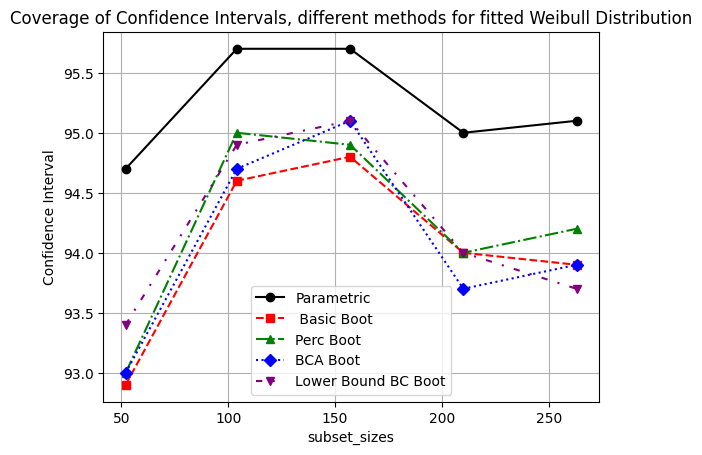

In [ ]:
def plot_coverage_confidence_intervals(list_1, list_2, list_3, list_4, list_5, subset_sizes, title):

# Parametric bounds
   plt.plot(subset_sizes, list_1, label='Parametric', marker='o', color='black', linestyle='-')

# Basic Bootstrap bounds
   plt.plot(subset_sizes, list_2, label=' Basic Boot', marker='s', color='red', linestyle='--')

# Percentile Bootstrap bounds
   plt.plot(subset_sizes, list_3, label='Perc Boot', marker='^', color='green', linestyle='-.')

# BCa Bootstrap bounds
   plt.plot(subset_sizes, list_4, label='BCA Boot', marker='D', color='blue', linestyle=':')

# BC Bootstrap bounds
   plt.plot(subset_sizes, list_5, label='Lower Bound BC Boot', marker='v', color='purple', linestyle=(0, (3, 5, 1, 5)))

   plt.xlabel('subset_sizes')
   plt.ylabel('Confidence Interval')
   plt.title(f"Coverage of Confidence Intervals, different methods for {title}")
   plt.legend()
   plt.grid(True)
   plt.show()

plot_coverage_confidence_intervals(list_parametric_coverage, list_classic_boot_coverage, list_percentile_boot_coverage, list_bca_boot_coverage, list_bc_boot_coverage, subset_sizes_avg, "fitted Weibull Distribution")

#

# III.2 - Computing coverage by simulating a non parametric distribution using Kernel Density Estimation

### This works automatically for every task / model as it is directly derived from your errors

### Again, we can check if the fit from the PDF corresponds well to our empirical distirbution (by definition, yes, it will)

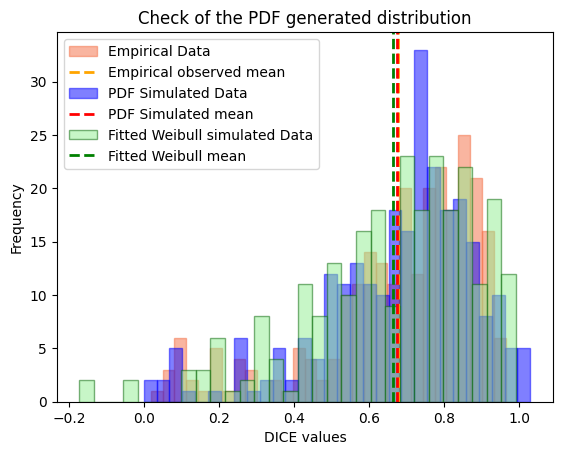

In [ ]:
n = len(errors)
kde = gaussian_kde(errors)
simulated_data = kde.resample(n)[0]

data_sample = stats.weibull_max.rvs(1.5934067748817824, loc=1, scale=0.36256930518582997, size=n)
weibull_mean = np.mean(data_sample)
plt.title("Check of the PDF generated distribution")
plt.hist(errors, bins=30, alpha=0.5, color='#f46d43', edgecolor='#f46d43',label='Empirical Data')
plt.axvline(empirical_mean, color='orange', linestyle='dashed', linewidth=2, label='Empirical observed mean')
plt.hist(simulated_data, bins=30, alpha=0.5, color='blue', edgecolor='blue', label='PDF Simulated Data')
plt.axvline(np.mean(simulated_data), color='r', linestyle='dashed', linewidth=2, label='PDF Simulated mean')
plt.hist(data_sample, bins=30, alpha=0.5, color='lightgreen', edgecolor='darkgreen',label='Fitted Weibull simulated Data')
plt.axvline(np.mean(data_sample), color='g', linestyle='dashed', linewidth=2, label='Fitted Weibull mean')
plt.xlabel("DICE values")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### And again, we check which method of computing Confidence Intervals work the best to capture the empirical mean (that we consider there as the real mean as we sample from the PDF)

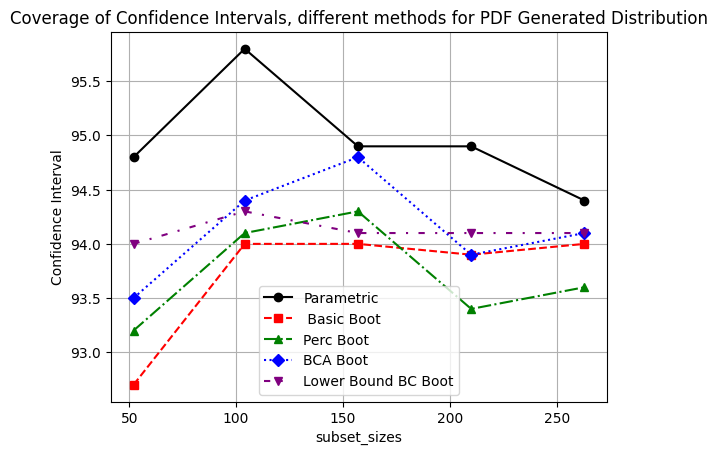

In [ ]:
def all_coverage_confidence_intervals_pdf(k, mean, num_samples=1000): # k number of progressive subsets you want, num_samples nb of simulation per subset

      alpha = 0.05 # Confidence level
      n = len(errors)

      list_classic_coverage = []
      list_classic_boot_coverage = []
      list_percentile_boot_coverage = []
      list_bca_boot_coverage = []
      list_bc_boot_coverage = []

      n = len(errors)
      subset_sizes_avg = np.linspace(n // k, n, k, dtype=int)
      sorted_data = np.sort(errors)
      kde = gaussian_kde(errors)


      for size in subset_sizes_avg:

          t_student = stats.t.ppf(1 - alpha / 2, size-1)
          classic_coverage_count = 0
          classic_boot_coverage_count = 0
          percentile_boot_coverage_count = 0
          bca_boot_coverage_count = 0
          bc_boot_coverage_count = 0

          for _ in range(num_samples):

              data_subset = kde.resample(size)[0]

              mean_subset = np.mean(data_subset)
              sem = np.std(data_subset)/np.sqrt(size)

              B = 250 # Bootstrap estimate
              bootstrap_indices_subset = np.random.choice(len(data_subset), size=(B, len(data_subset)), replace=True)

              bootstrap_subset = []
              for indices in bootstrap_indices_subset:
                  boot_mean_subset = np.mean(data_subset[indices])
                  bootstrap_subset.append(boot_mean_subset)

              bootstrapped_mean_subset = np.mean(bootstrap_subset)
              bootstrapped_std_error_subset = np.std(bootstrap_subset)

              lower = mean_subset - t_student * sem # Parametric method
              upper = mean_subset + t_student * sem

              if lower <= mean <= upper:
                  classic_coverage_count += 1

              lower_boot = np.percentile(bootstrap_subset , 100 * (alpha/2))
              upper_boot = np.percentile(bootstrap_subset, 100 * (1 - alpha / 2))

              if lower_boot <= empirical_mean <= upper_boot:
                  percentile_boot_coverage_count += 1
              if (2*mean_subset-upper_boot) <= mean <= (2*mean_subset-lower_boot):
                  classic_boot_coverage_count += 1

              # Acceleration
              jackknife_samples_subset = np.array([np.mean(np.delete(data_subset, i)) for i in range(len(data_subset))])
              jackknife_mean_subset = np.mean(jackknife_samples_subset)
              a_subset = np.sum((jackknife_mean_subset - jackknife_samples_subset) ** 3) / (6 * np.sum((jackknife_mean_subset - jackknife_samples_subset) ** 2) ** 1.5)

              # Bias correction
              z0_subset = stats.norm.ppf(np.mean(bootstrap_subset < mean_subset))
              z_alpha_subset = norm.ppf(alpha / 2)
              z_1_alpha_subset = norm.ppf(1 - alpha / 2)

              lower_percentile = norm.cdf(z0_subset + (z0_subset + z_alpha_subset) / (1 - a_subset * (z0_subset + z_alpha_subset))) * 100
              upper_percentile = norm.cdf(z0_subset + (z0_subset + z_1_alpha_subset) / (1 - a_subset * (z0_subset + z_1_alpha_subset))) * 100

              bca_boot_interval = np.percentile(bootstrap_subset, [lower_percentile, upper_percentile]) # BCA bootstrap

              if bca_boot_interval[0] <= mean <= bca_boot_interval[1]:
                  bca_boot_coverage_count += 1

              a_subset = 0

              lower_percentile = norm.cdf(z0_subset + (z0_subset + z_alpha_subset) / (1 - a_subset * (z0_subset + z_alpha_subset))) * 100
              upper_percentile = norm.cdf(z0_subset + (z0_subset + z_1_alpha_subset) / (1 - a_subset * (z0_subset + z_1_alpha_subset))) * 100

              bc_boot_interval = np.percentile(bootstrap_subset, [lower_percentile, upper_percentile]) # BC bootstrap

              if bc_boot_interval[0] <= mean <= bc_boot_interval[1]:
                  bc_boot_coverage_count += 1

          list_classic_coverage.append(classic_coverage_count / num_samples * 100)
          list_classic_boot_coverage.append(classic_boot_coverage_count / num_samples * 100)
          list_percentile_boot_coverage.append(percentile_boot_coverage_count / num_samples * 100)
          list_bca_boot_coverage.append(bca_boot_coverage_count / num_samples * 100)
          list_bc_boot_coverage.append(bc_boot_coverage_count / num_samples * 100)

      return subset_sizes_avg, list_classic_coverage, list_classic_boot_coverage, list_percentile_boot_coverage, list_bca_boot_coverage, list_bc_boot_coverage


subset_sizes_avg, list_parametric_coverage_pdf, list_classic_boot_coverage_pdf, list_percentile_boot_coverage_pdf, list_bca_boot_coverage_pdf, list_bc_boot_coverage_pdf = all_coverage_confidence_intervals_pdf(5, empirical_mean, 1000)
plot_coverage_confidence_intervals(list_parametric_coverage_pdf, list_classic_boot_coverage_pdf, list_percentile_boot_coverage_pdf, list_bca_boot_coverage_pdf, list_bc_boot_coverage_pdf, subset_sizes_avg, "PDF Generated Distribution")


# Save again the data in a JSON File

In [ ]:
# ...

# The following part is just an introduction of what is possible to do with Bayesian Statistics

But it is impossible to generalize to every dataset as it requires likelihood, priors etc..

# IV - Bayesian Statistics

Bayesian statistics is a subfield of statistics that fundamentally differs from classical frequentist statistics in its approach to inference.

Bayesian inference starts with a prior distribution that represents the initial belief about the parameters before any data is observed. This prior is updated as evidence is accumulated

The posterior distribution combines the prior distribution and the likelihood of the observed data. It represents the updated belief about the parameters after considering the evidence.

## IV.1 - Bayesian estimation

## Example of implementation if we want to estimate $\mu = mean(errors)$

In our example :

We are looking to identify the true mean $\mu$ of the errors of a model.

To do this, we **first** assume that the distribution of the model errors follows a certain law. This is the **Likelihood Model**.


Let's denote the individual error $e = (y\_test - y\_pred)$

We can make the hypothesis that $\text{e} \sim \mathcal{N}(\mu_e, \sigma_e^2)$.

As $errors = e^2$, squaring the errors gives a chi-square distribution:

$\text{errors} \sim \sigma_e^2 \chi^2_1 \left(\frac{\mu_e^2}{\sigma_e^2}\right)$

**Then**, we also have to make an assumption on the distribution of $μ$

The **prior distribution** represents our uncertainty about $μ$ before observing any data. It is a way of encoding any prior knowledge or belief about $μ$. We can easily make the following assumption

$\text{μ} \sim \mathcal{N}(m, SE)$

Where $m$ is the empirical mean of the errors, and SE its standard error ($\text{SE} = \frac{\sigma}{\sqrt{n}}$)

But this prior is too strong and thus ruins the bayesian analysis, because this prior is made according to the data we have already observed.

Instead of this, we'll make as a prior the conjuguate law of the likelihood, that \mu follows an inversed chi squared distribution with 1 degree of freedom:

$\text{μ} \sim Inv \mathcal{X}(1)$


**Finally**, using Bayes' theorem, we update our belief about $μ$ after observing the data:

\begin{equation}
P(\mu | D) = \frac{P(D|\mu) P(\mu)}{P(D)}
\end{equation}

where $P(D)$ is the marginal likelihood, ensuring that the posterior distribution is a valid probability distribution.

This will be the **posterior distribution**.

### Let's define our likelihood and priors


In order to simplify it, we can consider at first that the $e$ are distributed normally around 0, so that $\mu_e = 0$. It leads to calculating the density of $errors$ where $errors = e^2$, and $e \sim \mathcal{N}(0, \sigma_e^2)$

Squaring the errors gives a chi-square distribution:

$\text{errors} \sim \sigma_e^2 \chi^2_1$ which density can be written as :

\begin{equation}
f_X(x_i; 1) =
\begin{cases}
\frac{1}{\sigma_e \sqrt{2\pi x_i}} e^{-\frac{x_i}{2\sigma_e^2}} & \text{if } y \geq 0, \\
0 & \text{if } y < 0
\end{cases}
\end{equation}

But as $\mu_e = 0$, and $\mu = \mu_e^2 + σ_e^2$, we can replace $σ_e^2$ by $μ$

With the formula of the likelihood :

\begin{equation}
L(D|\mu) = \prod_{i=1}^{n} f_X(x_i; 1)
\end{equation}

This leads to the following formula:

\begin{equation}
L(D| \mu) = \left( \frac{1}{\sqrt{2\pi\mu}} \right)^n \left( \prod_{i=1}^{n} \frac{1}{\sqrt{x_i}} \right) e^{-\frac{n \bar{x}}{2\mu}}
\end{equation}


And for the prior, we take the conjugate formula of a chi squared distribution with 1 degree of freedom, so an inversed chi squared distribution, that can be written as followed :

\begin{equation}
f_{Inv-chi-2}(k) = f_{Inv-gamma}(k/2, 2) = \frac{2^{-k/2}}{\Gamma(k/2)} μ^{-k/2 - 1} e^{-1/(2μ)}
\end{equation}

With 1 degree of freedom :

\begin{equation}
prior(\mu|D) = f(\mu; 1) = \frac{2^{-1/2}}{\Gamma(1/2)} μ^{-1/2 - 1} e^{-1/(2μ)}
\end{equation}

That we can rewrite as

$$
prior(\mu|D) \sim \text{IG}\left(\frac{1}{2}, \frac{1}{2}\right)
$$

Leading to the posterior :  

$p(\mu \mid D) \propto L(D \mid \mu) \cdot prior(\mu \mid D)$

Substitute the expressions for the likelihood and the prior:

\begin{equation}
p(\mu \mid D) \propto \left( \frac{1}{\sqrt{2\pi\mu}} \right)^n \left( \prod_{i=1}^{n} \frac{1}{\sqrt{x_i}} \right) e^{-\frac{n \bar{x}}{2\mu}} \cdot \frac{2^{-1/2}}{\Gamma(1/2)} \mu^{-3/2} e^{-1/(2\mu)}
\end{equation}

Combining and simplifying the terms gives:
\begin{equation}
p(\mu \mid D) \propto \mu^{-\frac{n}{2}} e^{-\frac{n \bar{x}}{2\mu}} \cdot \mu^{-3/2} e^{-1/(2\mu)}
\end{equation}

Thus, the posterior distribution is proportional to:

\begin{equation}
p(\mu \mid D) \propto \mu^{-\left(\frac{n}{2} + \frac{3}{2}\right)} e^{-\left(\frac{n \bar{x}}{2} + \frac{1}{2}\right) \frac{1}{\mu}}
\end{equation}

This is the kernel of an Inverse Gamma distribution. Therefore, the posterior distribution is:

$$
\mu \mid D \sim \text{IG}\left(\frac{n}{2} + \frac{1}{2}, \frac{n \bar{x}}{2} + \frac{1}{2}\right)
$$

Where $\text{IG}(\alpha, \beta)$ denotes the Inverse Gamma distribution with shape parameter $\alpha$ and scale parameter $\beta$

And we have obtained the law followed by mu.


## IV.2 - Bayesian Credibility Intervals

- **Bayesian Credible Interval:** This interval provides a direct probability statement about the parameter. For example, a 95% credible interval means that there is a 95% probability that the true parameter value lies within this interval, given the observed data and the prior distribution.  The Credibility Interval is derived from the posterior distribution of the parameter, which combines prior information with the likelihood of the observed data. It is inherently subjective as it incorporates prior beliefs.

- **Confidence Interval:** This interval provides a probability statement about the procedure used to generate the interval, not about the parameter itself. For example, a 95% confidence interval means that if we were to repeat the experiment many times and calculate a 95% confidence interval each time, approximately 95% of those intervals would contain the true parameter value. It does not provide the probability that the true parameter lies within a specific interval calculated from a single experiment. The Confidence Interval is derived from the sampling distribution of the estimator under repeated sampling. It is objective in the sense that it does not incorporate prior beliefs, only the data and the model.

We'll keep the same example of our errors.

As a result, we'll keep the same prior, likelihood and thus posterior :

$$
prior(\mu|D) \sim \text{IG}\left(\frac{1}{2}, \frac{1}{2}\right)
$$

\begin{equation}
L(D| \mu) = \left( \frac{1}{\sqrt{2\pi\mu}} \right)^n \left( \prod_{i=1}^{n} \frac{1}{\sqrt{x_i}} \right) e^{-\frac{n \bar{x}}{2\mu}}
\end{equation}

$$
posterior(\mu \mid D) \sim \text{IG}\left(\frac{n}{2} + \frac{1}{2}, \frac{n \bar{x}}{2} + \frac{1}{2}\right)
$$

Let's now determine the credibility intervals for μ